### Import Library

In [68]:
# Sistem & I/O
import os
import time
import random

# Komputasi & Data
import numpy as np
import pandas as pd

# Visualisasi
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Pengolahan Citra
import cv2
from skimage.measure import moments_hu  # Hu Moments
from scipy.stats import skew            # Color Moments (skewness)

# Machine Learning - Scikit-learn
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import (
    LabelEncoder,
    StandardScaler,
    label_binarize
)
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold
)
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)


### Load Dataset

In [69]:
# from google.colab import drive
# drive.mount('/content/drive')

In [70]:
# Path lokal di Windows
local_path = r"C:\Users\Ega\Pictures\SKRIPSI\dataset_beras_fix"

def importImageFromLocal(base_path, folder_name, max_images=170):
    images = []
    path = os.path.join(base_path, folder_name)

    if not os.path.exists(path):
        print(f"Path {path} tidak ditemukan!")
        return images

    valid_extensions = (".png", ".jpg", ".jpeg")
    file_names = [f for f in os.listdir(path) if f.lower().endswith(valid_extensions)]

    for i, file_name in enumerate(file_names):
        if i >= max_images:
            break
        file_path = os.path.join(path, file_name)
        image = cv2.imread(file_path)
        if image is not None:
            images.append(image)
    print(f"Berhasil memuat {len(images)} gambar dari {folder_name}")
    return images

In [71]:
# Muat dataset dari 5 folder
imageBasmati = importImageFromLocal(local_path, "basmati")
imageIr64 = importImageFromLocal(local_path, "ir64")
imageKetanputih = importImageFromLocal(local_path, "ketanputih")
imagePandanwangi = importImageFromLocal(local_path, "pandanwangi")
imageRojolele = importImageFromLocal(local_path, "rojolele")

Berhasil memuat 170 gambar dari basmati
Berhasil memuat 170 gambar dari ir64
Berhasil memuat 170 gambar dari ketanputih
Berhasil memuat 170 gambar dari pandanwangi
Berhasil memuat 170 gambar dari rojolele


In [72]:
def displaySampleImagesPerClass(class_dict, k=5):
    for class_name, images in class_dict.items():
        if not images:
            print(f"[!] Tidak ada gambar dalam kelas '{class_name}'")
            continue

        sampled_images = random.sample(images, min(k, len(images)))

        fig, ax = plt.subplots(1, len(sampled_images), figsize=(3 * len(sampled_images), 3))
        plt.suptitle(f"Sampel Gambar dari Kelas: {class_name}", fontsize=14, fontweight='bold', color='darkblue')

        # Pastikan ax adalah iterable
        if len(sampled_images) == 1:
            ax = [ax]

        for i, img in enumerate(sampled_images):
            try:
                rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                ax[i].imshow(rgb_img)
                ax[i].axis('off')
                ax[i].set_title(f'Gambar {i+1}', fontsize=10)
            except Exception as e:
                print(f"Gagal menampilkan gambar ke-{i+1} dari '{class_name}': {e}")

        plt.tight_layout(rect=[0, 0, 1, 0.90])
        plt.show()


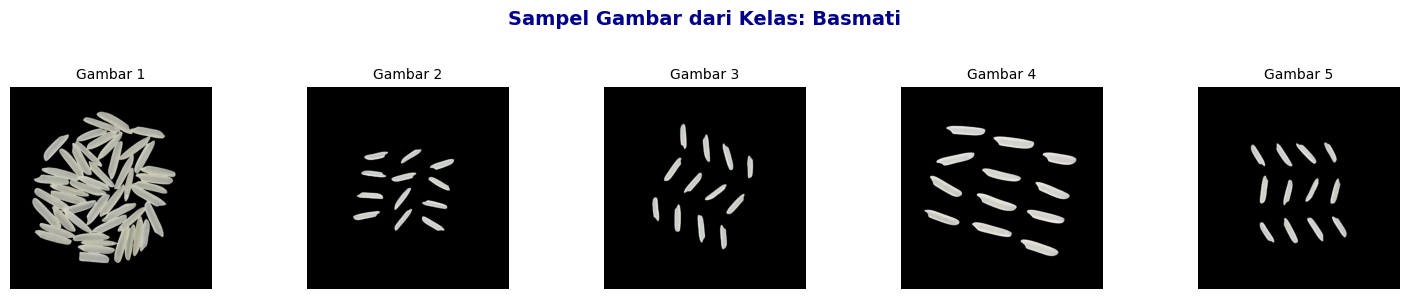

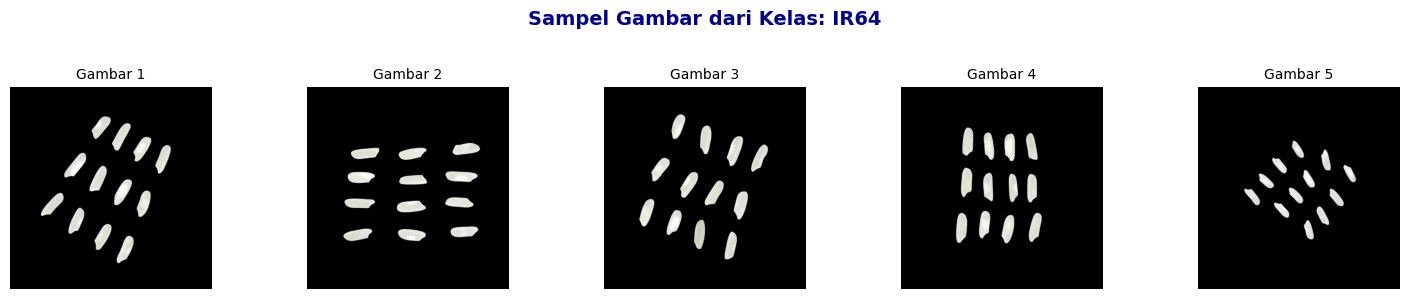

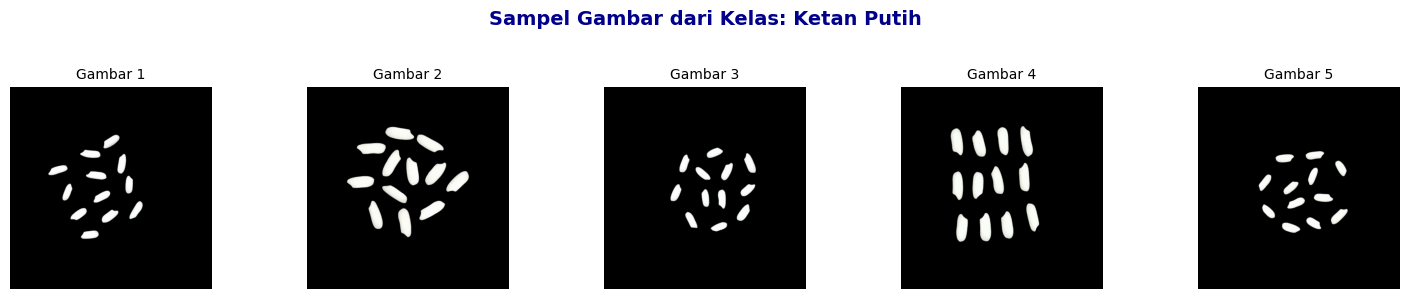

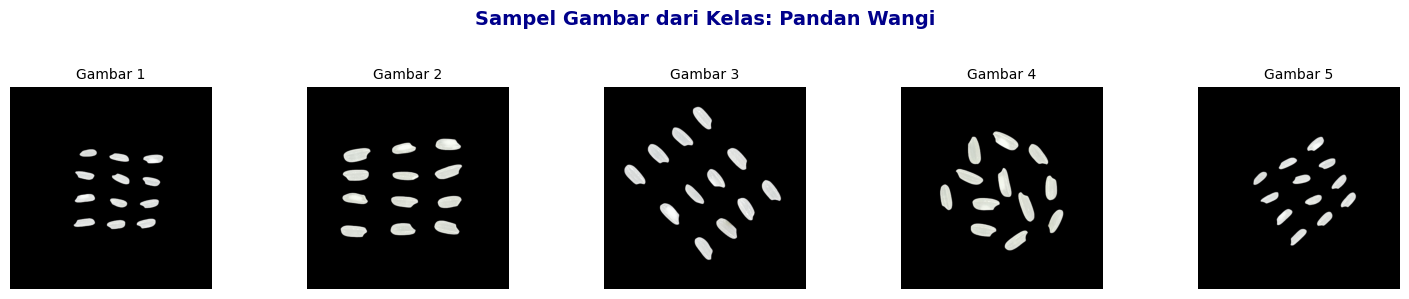

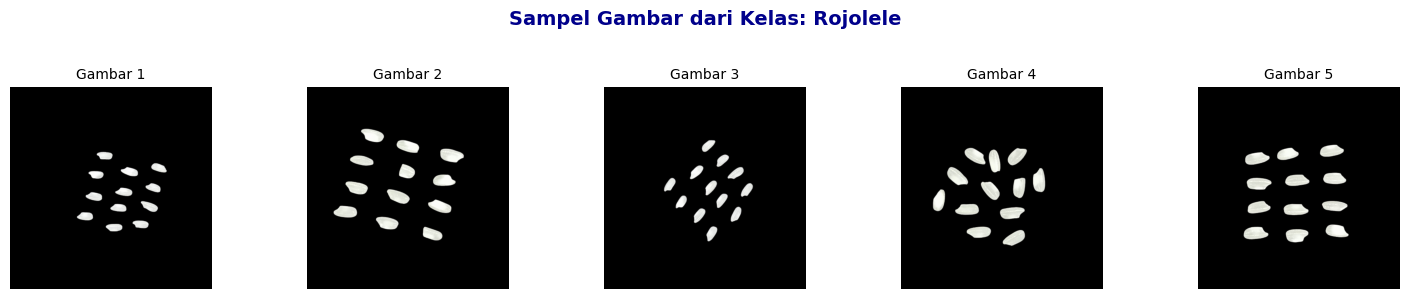

In [73]:
kelas_beras = {
    "Basmati": imageBasmati,
    "IR64": imageIr64,
    "Ketan Putih": imageKetanputih,
    "Pandan Wangi": imagePandanwangi,
    "Rojolele": imageRojolele
}

displaySampleImagesPerClass(kelas_beras, k=5)


### Preprocessing

### Augmentasi citra

In [74]:
# Fungsi augmentasi citra yang aman untuk fitur bentuk dan warna
def augmentImagesUniversal(images, num_augmented=3):
    augmented_images = []
    for img in images:
        augmented_images.append(img)  # Tambahkan gambar asli

        for _ in range(num_augmented):
            aug_img = img.copy()

            # 1. Rotasi acak ±30°
            angle = random.uniform(-30, 30)
            (h, w) = aug_img.shape[:2]
            center = (w // 2, h // 2)
            M = cv2.getRotationMatrix2D(center, angle, 1.0)
            aug_img = cv2.warpAffine(aug_img, M, (w, h))

            # 2. Flip horizontal/vertikal acak
            flip_type = random.choice([-1, 0, 1])
            aug_img = cv2.flip(aug_img, flip_type)

            # 3. Translasi acak (shift 10%)
            max_shift_x = int(0.1 * w)
            max_shift_y = int(0.1 * h)
            dx = random.randint(-max_shift_x, max_shift_x)
            dy = random.randint(-max_shift_y, max_shift_y)
            T = np.float32([[1, 0, dx], [0, 1, dy]])
            aug_img = cv2.warpAffine(aug_img, T, (w, h), borderValue=(0, 0, 0))

            # 4. Zoom (scaling) 90%–110%
            scale = random.uniform(0.9, 1.1)
            zoomed = cv2.resize(aug_img, None, fx=scale, fy=scale)
            zh, zw = zoomed.shape[:2]

            # Crop or pad to return to 500x500
            if zh > h:
                start_y = (zh - h) // 2
                zoomed = zoomed[start_y:start_y + h, :]
            elif zh < h:
                pad_y = (h - zh) // 2
                zoomed = cv2.copyMakeBorder(zoomed, pad_y, h - zh - pad_y, 0, 0, cv2.BORDER_CONSTANT, value=(0, 0, 0))

            if zw > w:
                start_x = (zw - w) // 2
                zoomed = zoomed[:, start_x:start_x + w]
            elif zw < w:
                pad_x = (w - zw) // 2
                zoomed = cv2.copyMakeBorder(zoomed, 0, 0, pad_x, w - zw - pad_x, cv2.BORDER_CONSTANT, value=(0, 0, 0))

            aug_img = zoomed

            # 5. Brightness & Contrast adjustment ringan
            hsv = cv2.cvtColor(aug_img, cv2.COLOR_BGR2HSV)
            h_, s_, v_ = cv2.split(hsv)
            brightness_shift = random.randint(-15, 15)
            contrast_shift = random.uniform(0.9, 1.1)
            v_ = np.clip((v_.astype(np.float32) * contrast_shift + brightness_shift), 0, 255).astype(np.uint8)
            hsv_aug = cv2.merge((h_, s_, v_))
            aug_img = cv2.cvtColor(hsv_aug, cv2.COLOR_HSV2BGR)

            augmented_images.append(aug_img)

    return augmented_images

In [75]:
# Terapkan augmentasi aman ke semua kelas beras
augBasmati = augmentImagesUniversal(imageBasmati)
augIr64 = augmentImagesUniversal(imageIr64)
augKetanputih = augmentImagesUniversal(imageKetanputih)
augPandanwangi = augmentImagesUniversal(imagePandanwangi)
augRojolele = augmentImagesUniversal(imageRojolele)

kelas_beras_augmented = {
    "Basmati": augBasmati,
    "IR64": augIr64,
    "Ketan Putih": augKetanputih,
    "Pandan Wangi": augPandanwangi,
    "Rojolele": augRojolele
}


In [76]:
# Validasi jumlah gambar hasil augmentasi
def validateAugmentedCounts(original, augmented, class_name):
    print(f"Kelas: {class_name}")
    print(f"- Jumlah gambar asli     : {len(original)}")
    print(f"- Jumlah setelah augment : {len(augmented)}")
    print(f"- Jumlah augment per gambar: {(len(augmented) - len(original)) // len(original)}")
    print("")

validateAugmentedCounts(imageBasmati, augBasmati, "Basmati")
validateAugmentedCounts(imageIr64, augIr64, "IR64")
validateAugmentedCounts(imageKetanputih, augKetanputih, "Ketan Putih")
validateAugmentedCounts(imagePandanwangi, augPandanwangi, "Pandan Wangi")
validateAugmentedCounts(imageRojolele, augRojolele, "Rojolele")


Kelas: Basmati
- Jumlah gambar asli     : 170
- Jumlah setelah augment : 680
- Jumlah augment per gambar: 3

Kelas: IR64
- Jumlah gambar asli     : 170
- Jumlah setelah augment : 680
- Jumlah augment per gambar: 3

Kelas: Ketan Putih
- Jumlah gambar asli     : 170
- Jumlah setelah augment : 680
- Jumlah augment per gambar: 3

Kelas: Pandan Wangi
- Jumlah gambar asli     : 170
- Jumlah setelah augment : 680
- Jumlah augment per gambar: 3

Kelas: Rojolele
- Jumlah gambar asli     : 170
- Jumlah setelah augment : 680
- Jumlah augment per gambar: 3



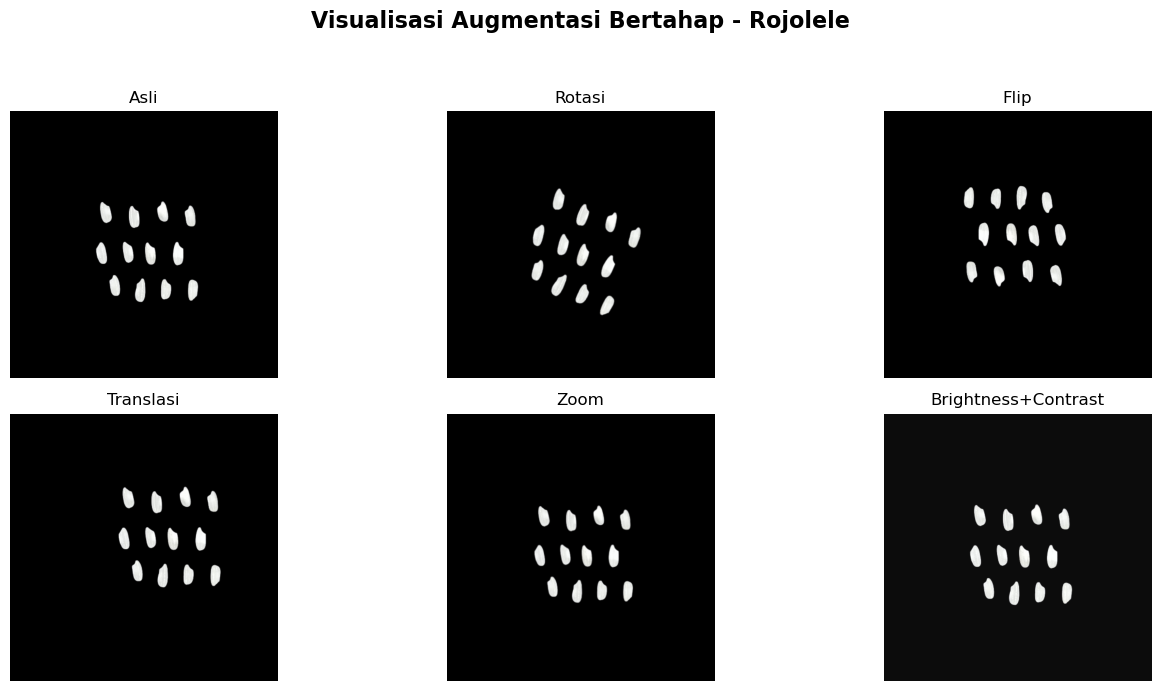

In [77]:
def showStepwiseAugmentation(image, class_name="Sample"):
    (h, w) = image.shape[:2]

    # 1. Rotasi
    angle = random.uniform(-30, 30)
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h))

    # 2. Flip
    flip_type = random.choice([-1, 0, 1])
    flipped = cv2.flip(image, flip_type)

    # 3. Translasi
    dx = random.randint(-int(0.1 * w), int(0.1 * w))
    dy = random.randint(-int(0.1 * h), int(0.1 * h))
    T = np.float32([[1, 0, dx], [0, 1, dy]])
    translated = cv2.warpAffine(image, T, (w, h), borderValue=(0, 0, 0))

    # 4. Zoom
    scale = random.uniform(0.9, 1.1)
    zoomed = cv2.resize(image, None, fx=scale, fy=scale)
    zh, zw = zoomed.shape[:2]
    if zh > h:
        start_y = (zh - h) // 2
        zoomed = zoomed[start_y:start_y + h, :]
    elif zh < h:
        pad_y = (h - zh) // 2
        zoomed = cv2.copyMakeBorder(zoomed, pad_y, h - zh - pad_y, 0, 0, cv2.BORDER_CONSTANT, value=(0, 0, 0))
    if zw > w:
        start_x = (zw - w) // 2
        zoomed = zoomed[:, start_x:start_x + w]
    elif zw < w:
        pad_x = (w - zw) // 2
        zoomed = cv2.copyMakeBorder(zoomed, 0, 0, pad_x, w - zw - pad_x, cv2.BORDER_CONSTANT, value=(0, 0, 0))

    # 5. Brightness & Contrast
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h_, s_, v_ = cv2.split(hsv)
    brightness_shift = random.randint(-15, 15)
    contrast_shift = random.uniform(0.9, 1.1)
    v_ = np.clip((v_.astype(np.float32) * contrast_shift + brightness_shift), 0, 255).astype(np.uint8)
    hsv_aug = cv2.merge((h_, s_, v_))
    bright_contrast = cv2.cvtColor(hsv_aug, cv2.COLOR_HSV2BGR)

    # Gambar dan judul
    images = [image, rotated, flipped, translated, zoomed, bright_contrast]
    titles = ['Asli', 'Rotasi', 'Flip', 'Translasi', 'Zoom', 'Brightness+Contrast']

    # Buat grid 3x2
    fig, axs = plt.subplots(2, 3, figsize=(14, 7))
    fig.suptitle(f'Visualisasi Augmentasi Bertahap - {class_name}', fontsize=16, fontweight='bold')

    for i in range(6):
        row = i // 3
        col = i % 3
        axs[row][col].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        axs[row][col].set_title(titles[i], fontsize=12)
        axs[row][col].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()

sample_img = imageRojolele[0]
showStepwiseAugmentation(sample_img, class_name="Rojolele")


In [78]:
def mask_largest_contour(image):
    """
    Fungsi untuk memask latar belakang gambar berdasarkan kontur terbesar.
    Menghasilkan citra dengan latar belakang disamarkan (hitam) agar fitur lebih fokus.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    _, binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return image  # fallback jika tidak ada kontur

    # Buat mask dan ambil kontur gabungan
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, contours, -1, 255, thickness=cv2.FILLED)

    # Terapkan mask ke gambar asli
    masked = cv2.bitwise_and(image, image, mask=mask)
    return masked


### Convert to HSV


In [79]:
# Fungsi konversi ke HSV dengan masking latar hitam
def convertToHSV_withMask(images):
    """
    Fungsi konversi ke HSV + masking menggunakan kontur utama (bukan hanya threshold Value).
    Lebih adaptif terhadap latar belakang non-hitam.
    """
    images_hsv_masked = []
    for idx, image in enumerate(images):
        if image is None:
            print(f"[WARNING] Gambar ke-{idx} adalah None, dilewati.")
            continue
        try:
            if len(image.shape) == 3 and image.shape[2] == 3:
                masked = mask_largest_contour(image)  # Gunakan masking kontur
                hsv = cv2.cvtColor(masked, cv2.COLOR_BGR2HSV)
                images_hsv_masked.append(hsv)
            else:
                print(f"[WARNING] Gambar ke-{idx} bukan BGR 3-channel, dilewati.")
        except Exception as e:
            print(f"[ERROR] Konversi HSV gagal pada gambar ke-{idx}: {e}")
    return images_hsv_masked


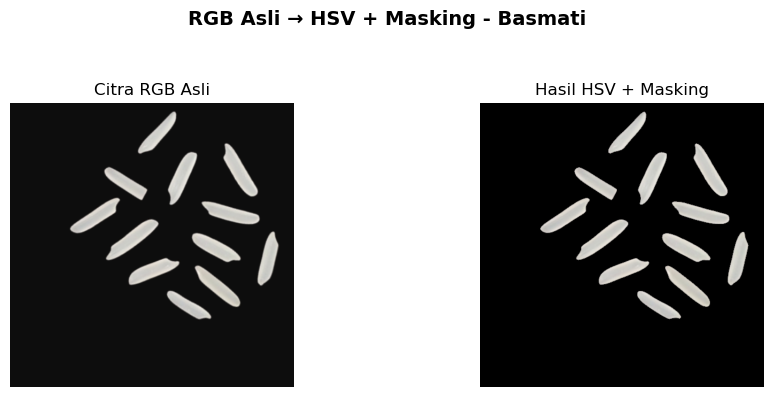

In [80]:
# Konversi semua kelas ke HSV dengan masking kontur
hsvBasmati = convertToHSV_withMask(augBasmati)
hsvIr64 = convertToHSV_withMask(augIr64)
hsvKetanputih = convertToHSV_withMask(augKetanputih)
hsvPandanwangi = convertToHSV_withMask(augPandanwangi)
hsvRojolele = convertToHSV_withMask(augRojolele)

# Simpan ke dalam dictionary agar bisa dipanggil fleksibel
hsv_dict = {
    "Basmati": hsvBasmati,
    "IR64": hsvIr64,
    "Ketan Putih": hsvKetanputih,
    "Pandan Wangi": hsvPandanwangi,
    "Rojolele": hsvRojolele
}

aug_dict = {
    "Basmati": augBasmati,
    "IR64": augIr64,
    "Ketan Putih": augKetanputih,
    "Pandan Wangi": augPandanwangi,
    "Rojolele": augRojolele
}

# Gunakan versi visualisasi yang konsisten
def displayHSVComparison(rgb_images, hsv_images, class_name="Sample", sample_index=0):
    if sample_index >= len(rgb_images) or sample_index >= len(hsv_images):
        print(f"[!] Index {sample_index} melebihi panjang data.")
        return

    rgb_image = rgb_images[sample_index]
    hsv_image = hsv_images[sample_index]

    # Konversi HSV ke BGR untuk ditampilkan
    hsv_bgr_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)

    plt.figure(figsize=(10, 4))
    plt.suptitle(f"RGB Asli → HSV + Masking - {class_name}", fontsize=14, fontweight='bold')

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB))
    plt.title("Citra RGB Asli")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(hsv_bgr_image, cv2.COLOR_BGR2RGB))
    plt.title("Hasil HSV + Masking")
    plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()

# ✅ Contoh visualisasi untuk kelas Basmati, gambar ke-1
sample_index = 170
displayHSVComparison(aug_dict["Basmati"], hsv_dict["Basmati"], class_name="Basmati", sample_index=sample_index)


# Ekstraksi warna Color moments

In [81]:
from scipy.stats import skew

# Fungsi untuk ekstraksi 3 momen statistik dari citra HSV yang telah dimasking
def extract_color_moments(image):
    features = []
    if image is None or len(image.shape) != 3 or image.shape[2] != 3:
        return [0] * 9  # Placeholder jika gagal

    for channel in cv2.split(image):  # H, S, V
        channel = channel.flatten().astype(np.float32)
        features.extend([
            np.mean(channel),
            np.std(channel),
            skew(channel)
        ])
    return features

# Fungsi untuk ekstraksi fitur dari sekumpulan citra HSV hasil masking
def extract_features_from_class(hsv_images, label):
    data = []
    for img in hsv_images:
        features = extract_color_moments(img)
        data.append(features + [label])
    return data


In [82]:
data_color_moments = []
data_color_moments += extract_features_from_class(hsvBasmati, "Basmati")
data_color_moments += extract_features_from_class(hsvIr64, "IR64")
data_color_moments += extract_features_from_class(hsvKetanputih, "Ketan Putih")
data_color_moments += extract_features_from_class(hsvPandanwangi, "Pandan Wangi")
data_color_moments += extract_features_from_class(hsvRojolele, "Rojolele")

columns = [
    "H_mean", "H_std", "H_skew",
    "S_mean", "S_std", "S_skew",
    "V_mean", "V_std", "V_skew",
    "Label"
]
df_color_moments = pd.DataFrame(data_color_moments, columns=columns)

# Tampilkan 5 baris pertama
print(df_color_moments.head())


     H_mean     H_std    H_skew    S_mean     S_std    S_skew    V_mean  \
0  1.523484  8.688487  7.118880  0.284716  1.546393  5.897327  7.632288   
1  1.539328  8.642970  6.686017  0.310908  1.660620  5.675095  7.814116   
2  1.628240  8.913359  6.560574  0.325480  1.687644  5.486192  8.620152   
3  1.656488  8.905851  6.351969  0.327128  1.689616  5.535324  8.091168   
4  1.542132  8.923116  7.249099  0.275108  1.489236  5.888260  7.711868   

       V_std    V_skew    Label  
0  39.132378  4.992344  Basmati  
1  39.859261  4.972512  Basmati  
2  42.772377  4.827050  Basmati  
3  39.685097  4.765128  Basmati  
4  39.401924  4.970555  Basmati  


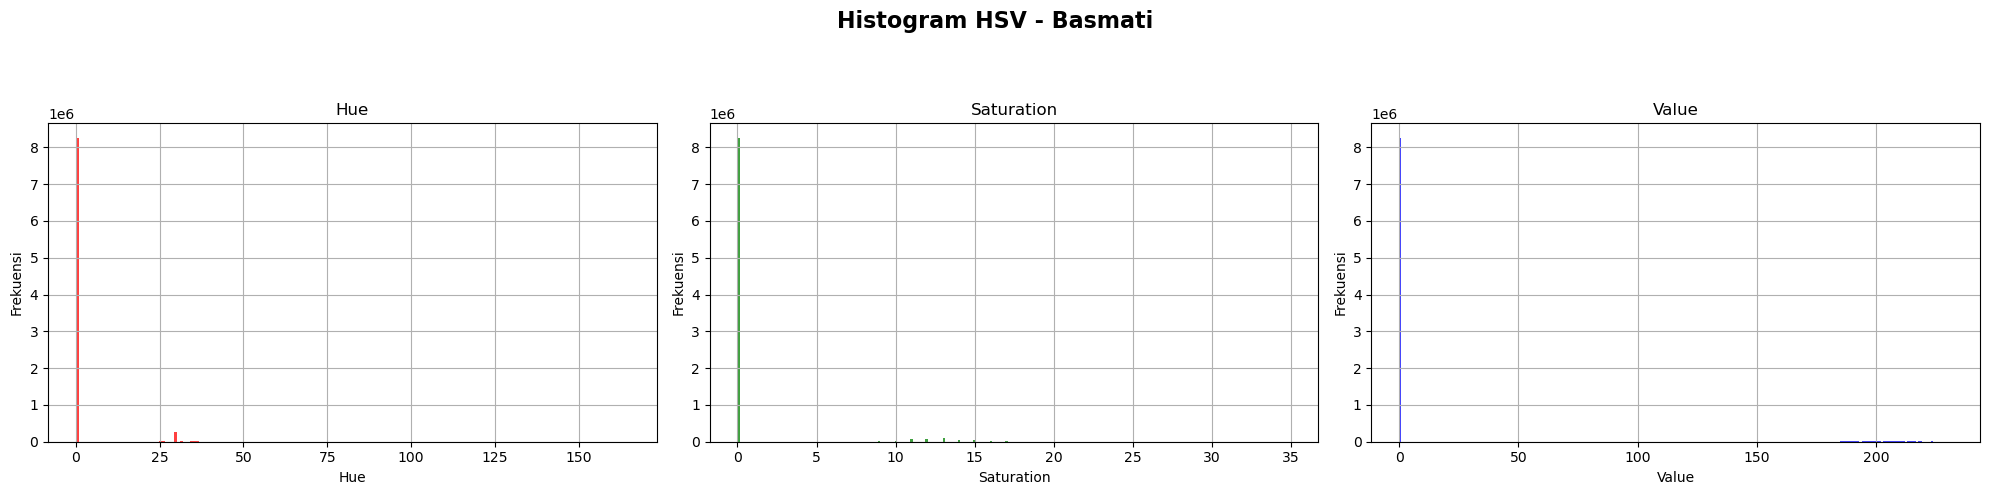

In [83]:
def plotHSVHistogram(hsv_image, class_name):
    h, s, v = cv2.split(hsv_image)

    plt.figure(figsize=(20, 5))
    plt.suptitle(f"Histogram HSV - {class_name}", fontsize=16, fontweight='bold')

    plt.subplot(1, 3, 1)
    plt.hist(h.ravel(), bins=180, color='red', alpha=0.75)
    plt.title("Hue")
    plt.xlabel("Hue")
    plt.ylabel("Frekuensi")
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.hist(s.ravel(), bins=256, color='green', alpha=0.75)
    plt.title("Saturation")
    plt.xlabel("Saturation")
    plt.ylabel("Frekuensi")
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.hist(v.ravel(), bins=256, color='blue', alpha=0.75)
    plt.title("Value")
    plt.xlabel("Value")
    plt.ylabel("Frekuensi")
    plt.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.show()

index = random.choice(range(len(hsvBasmati)))
hsv_sample = hsvBasmati[index]
original_sample = augBasmati[index]
plotHSVHistogram(hsv_sample, "Basmati")


### Konversi ke Grayscale

In [84]:
def convertToGrayscale(images):
    grayscale_images = []
    for image in images:
        if image is None:
            continue
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        grayscale_images.append(gray)
    return grayscale_images

### Gaussian Blur

In [85]:
def applyGaussianBlur(images, kernel_size=(5, 5)):
    blurred_images = []
    for image in images:
        if image is None:
            continue
        blurred = cv2.GaussianBlur(image, kernel_size, 0)
        blurred_images.append(blurred)
    return blurred_images

### Thresholding (Otsu)

In [86]:
def applyOtsuThreshold(images):
    thresh_images = []
    for image in images:
        if image is None:
            continue
        _, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        thresh_images.append(thresh)
    return thresh_images

### Morphological Cleaning (Opening)

In [87]:
def applyMorphology(images, operation="open", kernel_size=(3, 3)):
    morph_images = []
    kernel = np.ones(kernel_size, np.uint8)
    for image in images:
        if image is None:
            continue
        if operation == "open":
            cleaned = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
        elif operation == "close":
            cleaned = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
        else:
            cleaned = image
        morph_images.append(cleaned)
    return morph_images

### Pipeline Utama Preprocessing Hu Moments

In [88]:
def fullPreprocessingHuPipeline(images):
    gray = convertToGrayscale(images)
    blurred = applyGaussianBlur(gray)
    thresh = applyOtsuThreshold(blurred)
    morph = applyMorphology(thresh, operation="open")
    return morph

huPreprocessedBasmati = fullPreprocessingHuPipeline(augBasmati)
huPreprocessedIr64 = fullPreprocessingHuPipeline(augIr64)
huPreprocessedKetanputih = fullPreprocessingHuPipeline(augKetanputih)
huPreprocessedPandanwangi = fullPreprocessingHuPipeline(augPandanwangi)
huPreprocessedRojolele = fullPreprocessingHuPipeline(augRojolele)

In [89]:
# Fungsi visualisasi dengan label tahap-tahap preprocessing
def displayEachPreprocessingComparison(previous_stage_images, current_stage_images, 
                                       prev_stage_name, curr_stage_name, class_name="Sample", sample_index=0):
    if sample_index >= len(previous_stage_images) or sample_index >= len(current_stage_images):
        print(f"[!] Index {sample_index} melebihi panjang data.")
        return

    before = previous_stage_images[sample_index]
    after = current_stage_images[sample_index]

    plt.figure(figsize=(10, 4))
    plt.suptitle(f"{prev_stage_name} → {curr_stage_name} - {class_name}", fontsize=14, fontweight='bold')

    # Citra tahap sebelumnya
    cmap_before = 'gray' if len(before.shape) == 2 else None
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(before, cv2.COLOR_BGR2RGB) if cmap_before is None else before, cmap=cmap_before)
    plt.title(prev_stage_name)
    plt.axis('off')

    # Citra tahap saat ini
    cmap_after = 'gray' if len(after.shape) == 2 else None
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(after, cv2.COLOR_BGR2RGB) if cmap_after is None else after, cmap=cmap_after)
    plt.title(curr_stage_name)
    plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.show()

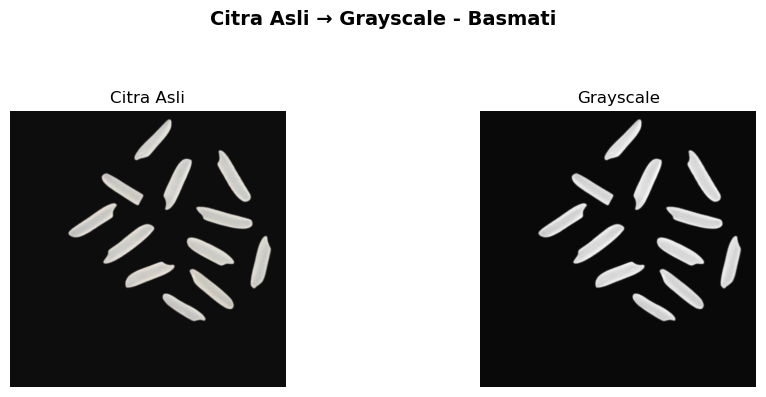

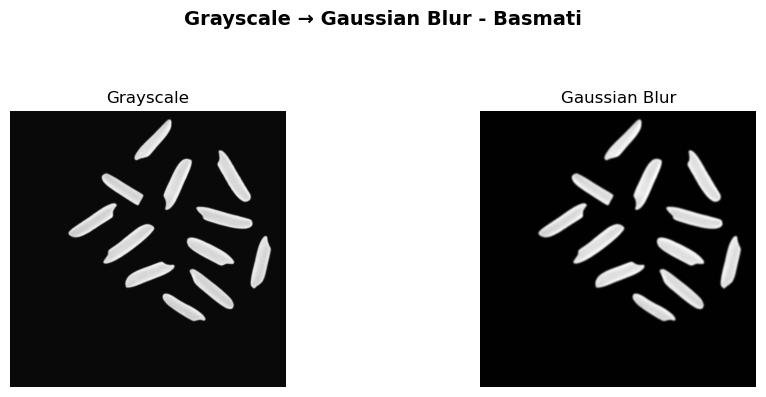

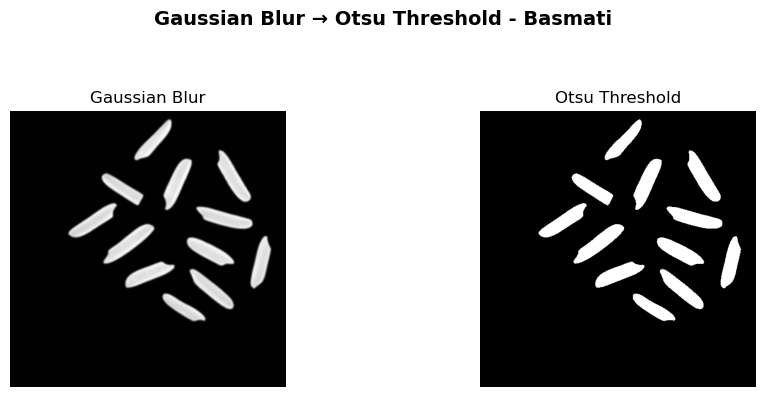

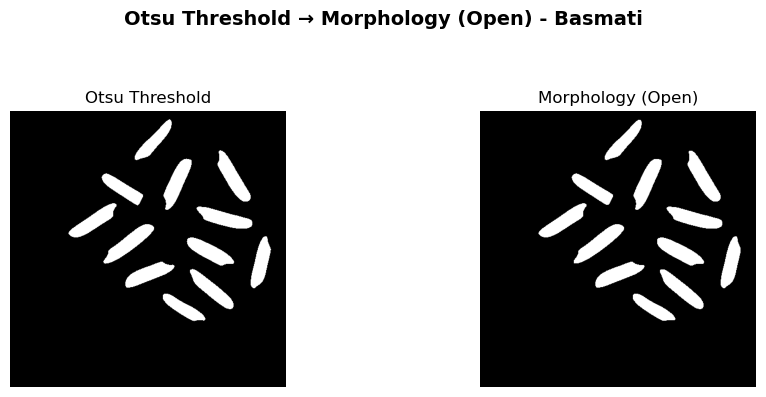

In [90]:
# 🔍 Pilih kelas & sample untuk Basmati
sample_index = 170  # Ganti sesuai kebutuhan (0, 1, 2, dst)
class_name = "Basmati"
original_images = augBasmati

# 🔁 Jalankan proses preprocessing per tahap untuk Basmati
gray_basmati = convertToGrayscale(original_images)
blur_basmati = applyGaussianBlur(gray_basmati)
thresh_basmati = applyOtsuThreshold(blur_basmati)
morph_basmati = applyMorphology(thresh_basmati)

# 📊 Visualisasi progresif per tahap untuk Basmati
displayEachPreprocessingComparison(original_images, gray_basmati, "Citra Asli", "Grayscale", class_name, sample_index)
displayEachPreprocessingComparison(gray_basmati, blur_basmati, "Grayscale", "Gaussian Blur", class_name, sample_index)
displayEachPreprocessingComparison(blur_basmati, thresh_basmati, "Gaussian Blur", "Otsu Threshold", class_name, sample_index)
displayEachPreprocessingComparison(thresh_basmati, morph_basmati, "Otsu Threshold", "Morphology (Open)", class_name, sample_index)


# Ekstraksi Hu Moments

In [91]:
def extract_hu_features_topN(preprocessed_images, label, min_area_threshold=50, top_n=3):
    data = []
    for idx, img in enumerate(preprocessed_images):
        if img is None:
            continue

        # Temukan kontur dari hasil threshold (morph)
        contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        valid_contours = [c for c in contours if cv2.contourArea(c) >= min_area_threshold]

        if len(valid_contours) == 0:
            print(f"[INFO] Gambar ke-{idx} kelas {label} tidak punya kontur valid.")
            continue

        # Ambil N kontur dengan luas terdekat ke rata-rata
        contour_areas = [cv2.contourArea(c) for c in valid_contours]
        mean_area = np.mean(contour_areas)
        closest_contours = sorted(valid_contours, key=lambda c: abs(cv2.contourArea(c) - mean_area))[:top_n]

        # Hitung Hu Moments log-scaled untuk setiap kontur terpilih
        hu_moments = []
        for c in closest_contours:
            m = cv2.moments(c)
            hu = cv2.HuMoments(m).flatten()
            hu_log = -np.sign(hu) * np.log10(np.abs(hu) + 1e-10)  # Skala log
            hu_moments.append(hu_log)

        # Ambil rata-rata dari N kontur
        if hu_moments:
            mean_hu = np.mean(hu_moments, axis=0)
            data.append(mean_hu.tolist() + [label])

    return data


In [92]:
data_hu_moments = []
data_hu_moments += extract_hu_features_topN(huPreprocessedBasmati, "Basmati")
data_hu_moments += extract_hu_features_topN(huPreprocessedIr64, "IR64")
data_hu_moments += extract_hu_features_topN(huPreprocessedKetanputih, "Ketan Putih")
data_hu_moments += extract_hu_features_topN(huPreprocessedPandanwangi, "Pandan Wangi")
data_hu_moments += extract_hu_features_topN(huPreprocessedRojolele, "Rojolele")

columns_hu = [f"Hu_{i+1}" for i in range(7)] + ["Label"]
df_hu_moments = pd.DataFrame(data_hu_moments, columns=columns_hu)
print("Contoh hasil ekstraksi Hu Moments:")
print(df_hu_moments.head())


Contoh hasil ekstraksi Hu Moments:
       Hu_1      Hu_2      Hu_3      Hu_4      Hu_5      Hu_6      Hu_7  \
0  0.432322  0.959318  3.362504  4.117998  2.382245  1.720609 -7.990061   
1  0.416781  0.921168  3.390632  4.174367  2.637253  2.122463  8.029996   
2  0.418997  0.926586  3.449678  4.274712  2.777830 -1.764635  8.148540   
3  0.419291  0.927066  3.436459  4.258582  3.002683 -1.857774 -8.159269   
4  0.440736  0.979557  3.439677  4.252779 -3.110954 -1.774841 -3.120415   

     Label  
0  Basmati  
1  Basmati  
2  Basmati  
3  Basmati  
4  Basmati  


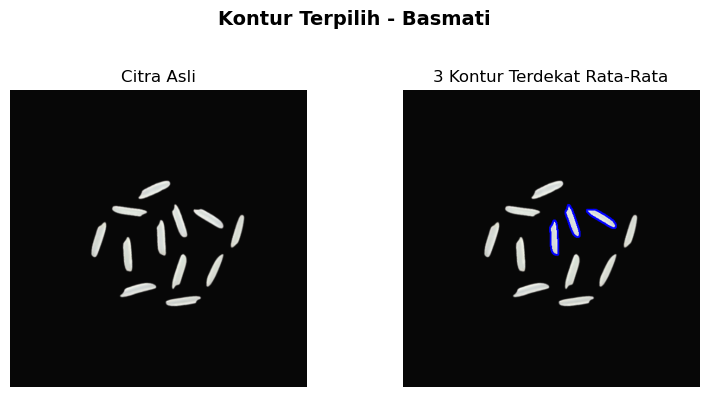

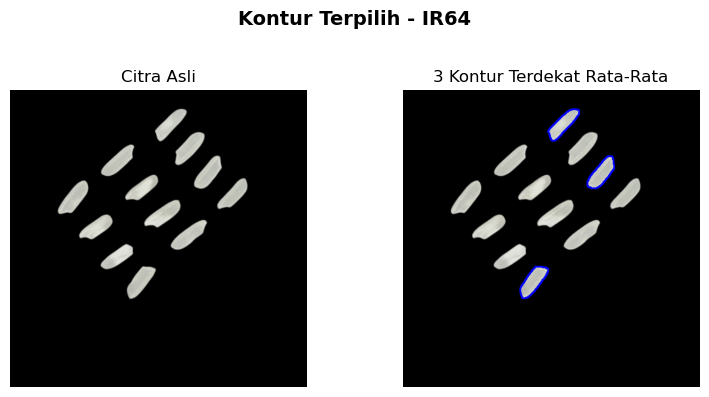

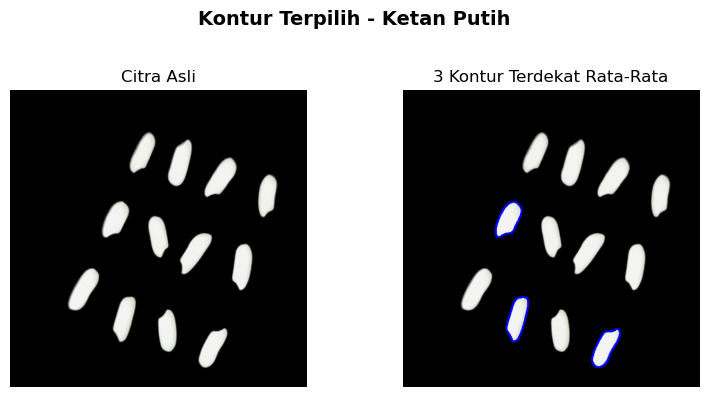

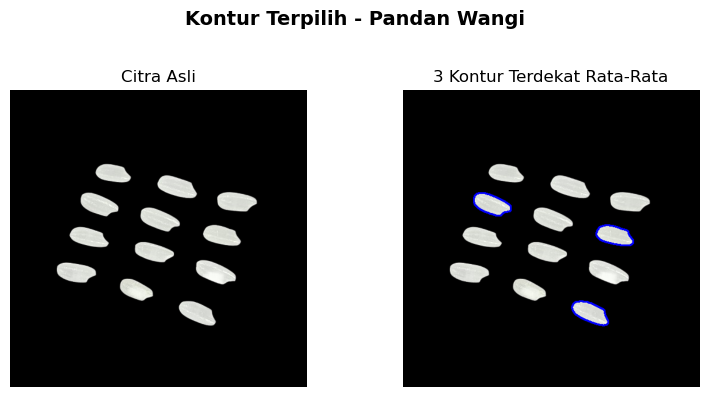

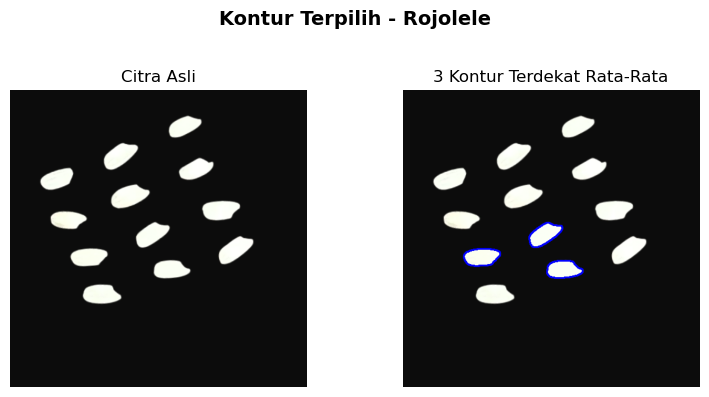

In [93]:
def display_selected_contours_sample(original_images, binary_images, class_name, top_n=3):
    index = random.choice(range(len(binary_images)))
    original = original_images[index]
    binary = binary_images[index]

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = [c for c in contours if cv2.contourArea(c) >= 50]

    if not contours:
        print(f"[WARNING] Tidak ditemukan kontur valid pada kelas {class_name}.")
        return

    mean_area = np.mean([cv2.contourArea(c) for c in contours])
    selected = sorted(contours, key=lambda c: abs(cv2.contourArea(c) - mean_area))[:top_n]

    img_vis = original.copy()
    cv2.drawContours(img_vis, selected, -1, (255, 0, 0), 2)

    plt.figure(figsize=(8, 4))
    plt.suptitle(f"Kontur Terpilih - {class_name}", fontsize=14, fontweight='bold')

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title("Citra Asli")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
    plt.title(f"{top_n} Kontur Terdekat Rata-Rata")
    plt.axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()

display_selected_contours_sample(augBasmati, huPreprocessedBasmati, "Basmati")
display_selected_contours_sample(augIr64, huPreprocessedIr64, "IR64")
display_selected_contours_sample(augKetanputih, huPreprocessedKetanputih, "Ketan Putih")
display_selected_contours_sample(augPandanwangi, huPreprocessedPandanwangi, "Pandan Wangi")
display_selected_contours_sample(augRojolele, huPreprocessedRojolele, "Rojolele")


### Gabungkan Fitur Color Moments + Hu Moments

In [94]:
# Tampilkan jumlah baris untuk validasi awal
print("📊 Jumlah baris:")
print(f"- Fitur Color Moments : {len(df_color_moments)}")
print(f"- Fitur Hu Moments     : {len(df_hu_moments)}")

# Validasi kesesuaian panjang data
if len(df_color_moments) != len(df_hu_moments):
    raise ValueError(f"❌ Jumlah baris tidak cocok: Color Moments ({len(df_color_moments)}), Hu Moments ({len(df_hu_moments)})")

# Validasi kesesuaian label
if not all(df_color_moments["Label"].values == df_hu_moments["Label"].values):
    raise ValueError("❌ Label tidak konsisten antara Color Moments dan Hu Moments")

print("✅ Jumlah baris & label sesuai, siap digabung.")

# Gabungkan fitur tanpa label + tambahkan label terakhir
df_combined = pd.concat([
    df_color_moments.drop(columns=["Label"]).reset_index(drop=True),
    df_hu_moments.drop(columns=["Label"]).reset_index(drop=True),
    df_color_moments["Label"].reset_index(drop=True)
], axis=1)

print("✅ Data gabungan sebelum normalisasi:")
print(df_combined.head())


📊 Jumlah baris:
- Fitur Color Moments : 3400
- Fitur Hu Moments     : 3400
✅ Jumlah baris & label sesuai, siap digabung.
✅ Data gabungan sebelum normalisasi:
     H_mean     H_std    H_skew    S_mean     S_std    S_skew    V_mean  \
0  1.523484  8.688487  7.118880  0.284716  1.546393  5.897327  7.632288   
1  1.539328  8.642970  6.686017  0.310908  1.660620  5.675095  7.814116   
2  1.628240  8.913359  6.560574  0.325480  1.687644  5.486192  8.620152   
3  1.656488  8.905851  6.351969  0.327128  1.689616  5.535324  8.091168   
4  1.542132  8.923116  7.249099  0.275108  1.489236  5.888260  7.711868   

       V_std    V_skew      Hu_1      Hu_2      Hu_3      Hu_4      Hu_5  \
0  39.132378  4.992344  0.432322  0.959318  3.362504  4.117998  2.382245   
1  39.859261  4.972512  0.416781  0.921168  3.390632  4.174367  2.637253   
2  42.772377  4.827050  0.418997  0.926586  3.449678  4.274712  2.777830   
3  39.685097  4.765128  0.419291  0.927066  3.436459  4.258582  3.002683   
4  39.40192

### Pisahkan Fitur dan Label

In [95]:
# Pastikan label bersih dari whitespace yang tidak sengaja
df_combined["Label"] = df_combined["Label"].str.strip()

# Pisahkan fitur dan label
X = df_combined.drop(columns=["Label"])
y = df_combined["Label"]


### Split Data (Sebelum Normalisasi)

In [96]:
# Stratified split: agar distribusi label tetap terjaga
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# Tampilkan distribusi label
print("Jumlah total data train:", len(X_train))
print("Distribusi label di train:\n", y_train.value_counts())
print("\nJumlah total data test:", len(X_test))
print("Distribusi label di test:\n", y_test.value_counts())

Jumlah total data train: 2550
Distribusi label di train:
 Label
Rojolele        510
Ketan Putih     510
Basmati         510
Pandan Wangi    510
IR64            510
Name: count, dtype: int64

Jumlah total data test: 850
Distribusi label di test:
 Label
Pandan Wangi    170
IR64            170
Basmati         170
Ketan Putih     170
Rojolele        170
Name: count, dtype: int64


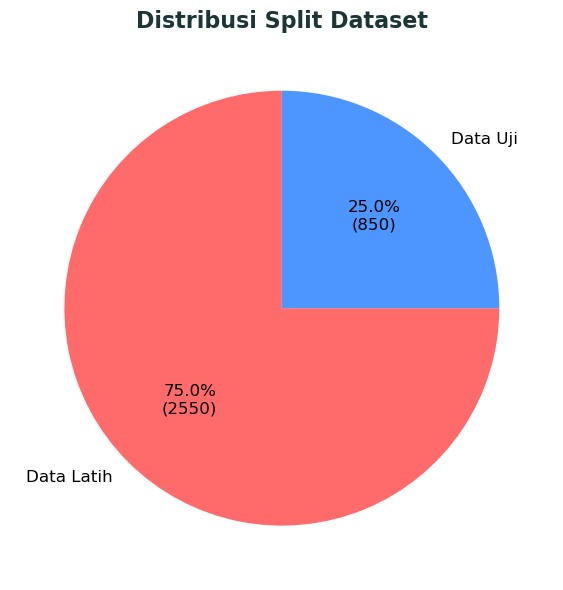

In [97]:
# Gabungkan kembali X dan y untuk visualisasi pie chart
train_data = pd.DataFrame(X_train.copy())
train_data["Label"] = y_train.values

test_data = pd.DataFrame(X_test.copy())
test_data["Label"] = y_test.values

# Visualisasi sederhana: Split Train vs Test (warna merah & biru)
def plot_simple_split_pie(X_train, X_test):
    sizes = [len(X_train), len(X_test)]
    labels = ['Data Latih', 'Data Uji']
    colors = ['#FF6B6B', '#4D96FF']  # merah dan biru

    plt.figure(figsize=(6, 6))
    plt.pie(
        sizes,
        labels=labels,
        autopct=lambda p: f'{p:.1f}%\n({int(p * sum(sizes) / 100)})',
        colors=colors,
        startangle=90,
        textprops={'fontsize': 12, 'color': 'black'}
    )
    plt.title('Distribusi Split Dataset', fontsize=16, fontweight='bold', color='#1A3636')
    plt.tight_layout()
    plt.show()

# Panggil fungsi
plot_simple_split_pie(X_train, X_test)


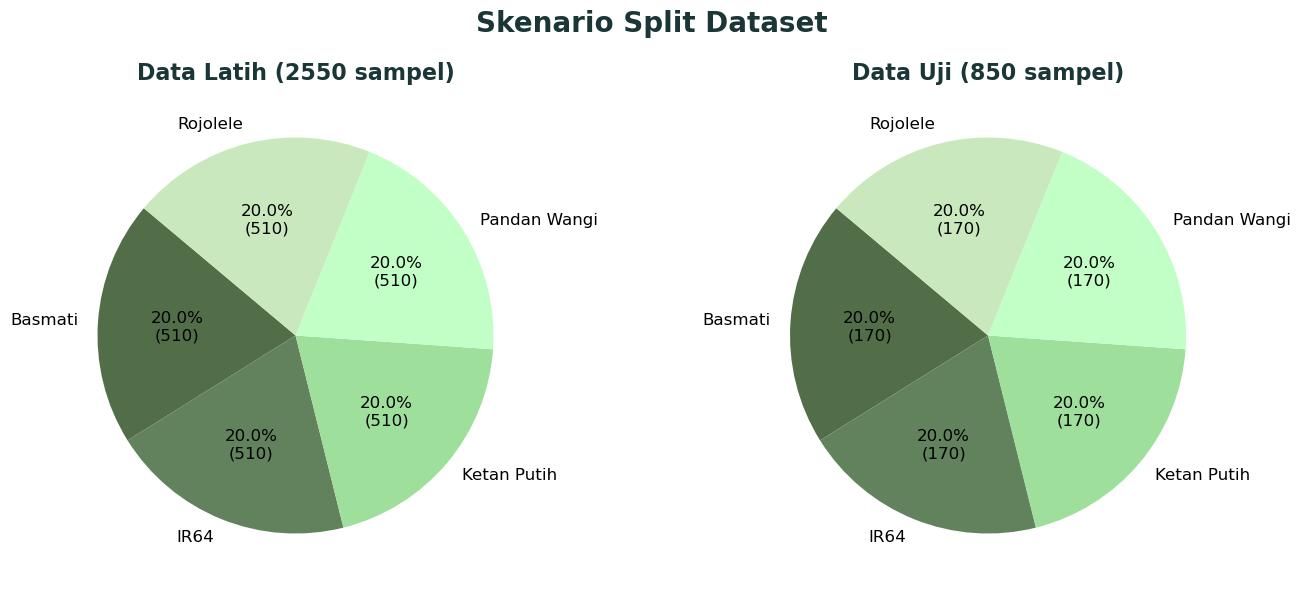

In [98]:
# Fungsi visualisasi pie chart
def train_test_split_plot(train_data, test_data):
    colors = ['#526E48', '#62825D', '#9EDF9C', '#C2FFC7', '#CAE8BD']

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    subsets = [
        (train_data, 'Data Latih'),
        (test_data, 'Data Uji')
    ]

    for i, (subset, subset_name) in enumerate(subsets):
        subset_category_counts = subset['Label'].value_counts().sort_index()
        subset_counts = subset_category_counts.values.tolist()
        total_count = len(subset)
        label_names = subset_category_counts.index.tolist()

        axs[i].pie(
            subset_counts,
            labels=label_names,
            autopct=lambda p: f'{p:.1f}%\n({int(p * total_count / 100)})',
            colors=colors,
            startangle=140,
            textprops={'color': 'black', 'fontsize': 12}
        )

        axs[i].set_title(f'{subset_name} ({total_count} sampel)', fontsize=16, fontweight='bold', color='#1A3636')

    plt.suptitle('Skenario Split Dataset', fontsize=20, fontweight='bold', color='#1A3636')
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

# Tampilkan pie chart distribusi label
train_test_split_plot(train_data, test_data)


### Normalisasi Menggunakan Data Latih

In [99]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Simpan Scaler

In [100]:
import os
import joblib

# Path direktori lokal 'save_model' relatif terhadap notebook
local_dir = os.path.join(os.getcwd(), "modelv5")
os.makedirs(local_dir, exist_ok=True)

# Path file scaler
scaler_path = os.path.join(local_dir, "scaler_new.pkl")

# Simpan scaler
joblib.dump(scaler, scaler_path)
print(f"✅ Scaler berhasil disimpan ke: {scaler_path}")

✅ Scaler berhasil disimpan ke: c:\Users\Ega\Pictures\Project\deteksi-helm-yolo-main\modelv5\scaler_new.pkl


### Dokumentasi Data Normalisasi (Opsional)

In [101]:
# Buat DataFrame hasil normalisasi
df_train_normalized = pd.DataFrame(X_train_scaled, columns=X.columns)
df_train_normalized["Label"] = y_train.values

df_test_normalized = pd.DataFrame(X_test_scaled, columns=X.columns)
df_test_normalized["Label"] = y_test.values

# Gabungkan untuk dokumentasi
df_all_normalized = pd.concat([df_train_normalized, df_test_normalized], ignore_index=True)

# Simpan ke file
local_dir = os.path.join(os.getcwd(), "modelv5")
os.makedirs(local_dir, exist_ok=True)

# Path file CSV normalisasi
normalized_path = os.path.join(local_dir, "fitur_normalisasi_new.csv")

# Simpan DataFrame ke CSV
df_all_normalized.to_csv(normalized_path, index=False)
print(f"✅ Fitur normalisasi disimpan ke: {normalized_path}")


✅ Fitur normalisasi disimpan ke: c:\Users\Ega\Pictures\Project\deteksi-helm-yolo-main\modelv5\fitur_normalisasi_new.csv


### Modeling (Support Vector Machine)

In [ ]:
# # Inisialisasi model SVM dengan kernel RBF (bisa diganti 'linear' atau 'poly')
# svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)

# # Latih model menggunakan data train
# svm_model.fit(X_train_scaled, y_train)


In [110]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np

# Grid parameter manual (gamma eksplisit)
param_grid_manual = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.1, 0.05, 0.01, 0.005, 0.001],
    'kernel': ['rbf']
}

In [111]:
# GridSearchCV
grid_manual = GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid=param_grid_manual,
    cv=5,
    n_jobs=-1,
    return_train_score=True
)
grid_manual.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [0.1, 0.05, 0.01, 0.005, 0.001],
                         'kernel': ['rbf']},
             return_train_score=True)

In [112]:
# Simpan semua hasil ke dalam DataFrame
cv_results_df = pd.DataFrame(grid_manual.cv_results_)
param_cols = ['param_C', 'param_gamma', 'param_kernel', 'mean_test_score', 'std_test_score']
cv_summary = cv_results_df[param_cols].sort_values(by='mean_test_score', ascending=False).reset_index(drop=True)

# Tampilkan tabel hasil tuning
print("\n🔍 Hasil GridSearchCV (disortir dari skor tertinggi):")
print(cv_summary)


🔍 Hasil GridSearchCV (disortir dari skor tertinggi):
    param_C  param_gamma param_kernel  mean_test_score  std_test_score
0     100.0        0.100          rbf         0.973333        0.008374
1      10.0        0.100          rbf         0.966275        0.014953
2     100.0        0.050          rbf         0.963922        0.012314
3      10.0        0.050          rbf         0.959608        0.014705
4     100.0        0.010          rbf         0.955686        0.013391
5       1.0        0.100          rbf         0.953725        0.009654
6       1.0        0.050          rbf         0.945882        0.007081
7     100.0        0.005          rbf         0.944706        0.012610
8      10.0        0.010          rbf         0.939608        0.011985
9      10.0        0.005          rbf         0.924314        0.008821
10    100.0        0.001          rbf         0.922353        0.007502
11      1.0        0.010          rbf         0.907451        0.009717
12     10.0        0.00

In [113]:
# Simpan model terbaik
best_params = grid_manual.best_params_
best_model = grid_manual.best_estimator_

# Evaluasi model terbaik
y_pred = best_model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)

# Tampilkan hasil evaluasi
print("\n✅ Parameter Terbaik:")
print(f" - C      : {best_params['C']}")
print(f" - Kernel : {best_params['kernel']}")
print(f" - Gamma  : {best_params['gamma']}")
print(f"\n🎯 Akurasi pada Data Uji : {acc:.4f}\n")

print("📊 Classification Report:")
print(classification_report(y_test, y_pred))


✅ Parameter Terbaik:
 - C      : 100
 - Kernel : rbf
 - Gamma  : 0.1

🎯 Akurasi pada Data Uji : 0.9824

📊 Classification Report:
              precision    recall  f1-score   support

     Basmati       1.00      1.00      1.00       170
        IR64       0.98      0.96      0.97       170
 Ketan Putih       0.97      0.98      0.98       170
Pandan Wangi       0.98      0.97      0.97       170
    Rojolele       0.99      0.99      0.99       170

    accuracy                           0.98       850
   macro avg       0.98      0.98      0.98       850
weighted avg       0.98      0.98      0.98       850



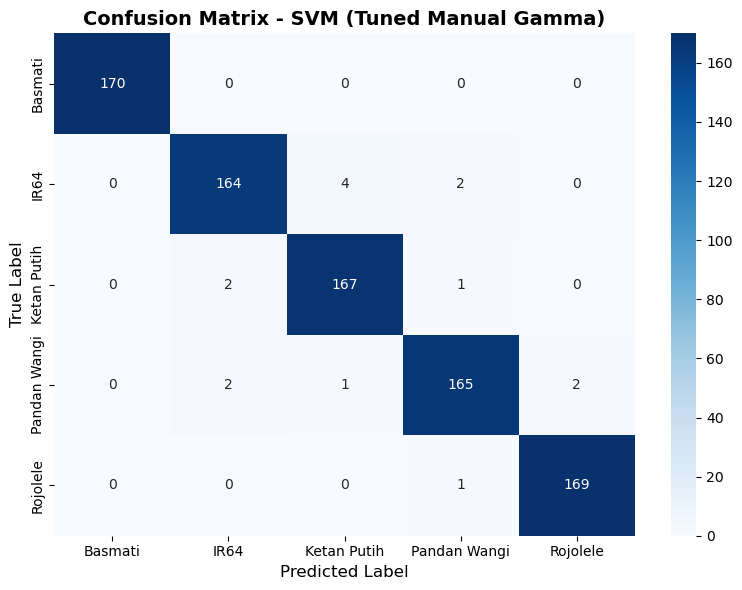

In [114]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Buat confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=best_model.classes_)

# Visualisasi heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - SVM (Tuned Manual Gamma)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


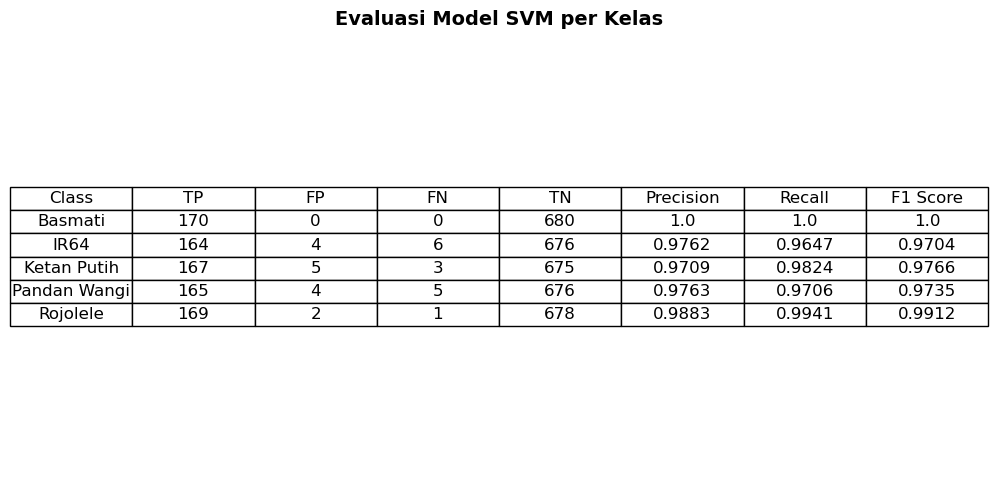

In [115]:
from sklearn.metrics import multilabel_confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Buat confusion matrix multilabel berdasarkan hasil prediksi best_model
class_labels = sorted(np.unique(y_test))  # urutkan label
cm_per_class = multilabel_confusion_matrix(y_test, y_pred, labels=class_labels)

# Hitung metrik evaluasi per kelas
eval_data = []
for idx, label in enumerate(class_labels):
    tn, fp, fn, tp = cm_per_class[idx].ravel()

    precision = tp / (tp + fp + 1e-10)
    recall = tp / (tp + fn + 1e-10)
    f1 = 2 * precision * recall / (precision + recall + 1e-10)

    eval_data.append({
        "Class": label,
        "TP": tp,
        "FP": fp,
        "FN": fn,
        "TN": tn,
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "F1 Score": round(f1, 4)
    })

# Buat DataFrame hasil evaluasi
df_eval = pd.DataFrame(eval_data)

# Visualisasi sebagai tabel
fig, ax = plt.subplots(figsize=(10, 2 + len(class_labels) * 0.6))
ax.axis('off')
table = ax.table(cellText=df_eval.values,
                 colLabels=df_eval.columns,
                 cellLoc='center',
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
plt.title("Evaluasi Model SVM per Kelas", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


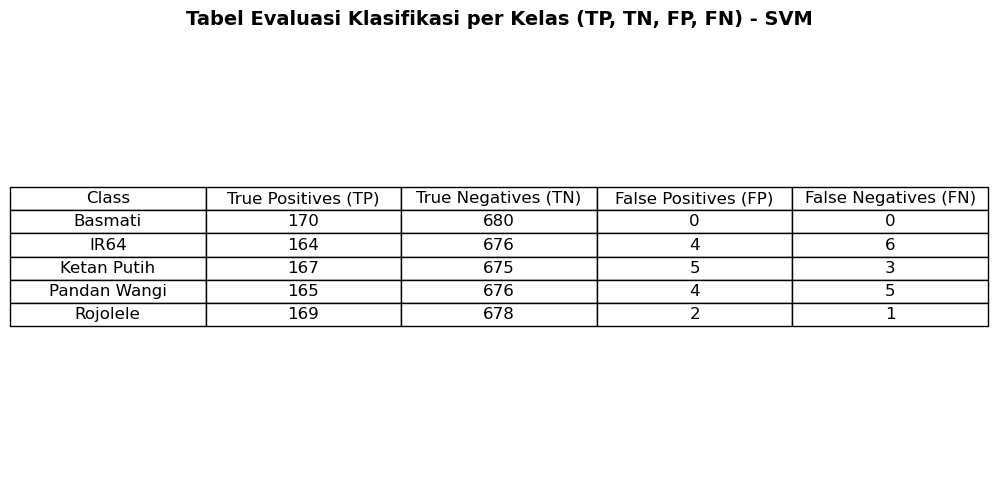

In [116]:
from sklearn.metrics import multilabel_confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Langkah 1: Buat confusion matrix multilabel
labels = sorted(np.unique(y_test))
cm = multilabel_confusion_matrix(y_test, y_pred, labels=labels)

# Langkah 2: Hitung TP, TN, FP, FN untuk setiap kelas
rows = []
for idx, label in enumerate(labels):
    tn, fp, fn, tp = cm[idx].ravel()
    rows.append({
        "Class": label,
        "True Positives (TP)": tp,
        "True Negatives (TN)": tn,
        "False Positives (FP)": fp,
        "False Negatives (FN)": fn
    })

df_confusion = pd.DataFrame(rows)

# Langkah 3: Visualisasi sebagai tabel
fig, ax = plt.subplots(figsize=(10, 2 + len(labels) * 0.6))
ax.axis('off')
table = ax.table(cellText=df_confusion.values,
                 colLabels=df_confusion.columns,
                 cellLoc='center',
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
plt.title("Tabel Evaluasi Klasifikasi per Kelas (TP, TN, FP, FN) - SVM", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [117]:
import os
import joblib

# Simpan model hasil GridSearchCV (gamma manual)
local_dir = os.path.join(os.getcwd(), "modelv5")
os.makedirs(local_dir, exist_ok=True)

# Path file model
model_path = os.path.join(local_dir, "svm_model_manual_gamma.pkl")

# Simpan model terbaik
joblib.dump(best_model, model_path)
print(f"✅ Model SVM (Gamma Manual) disimpan ke: {model_path}")

✅ Model SVM (Gamma Manual) disimpan ke: c:\Users\Ega\Pictures\Project\deteksi-helm-yolo-main\modelv5\svm_model_manual_gamma.pkl


In [118]:
# Contoh prediksi pada satu data uji
sample_index = 190  # ubah sesuai kebutuhan
sample_features = X_test_scaled[sample_index].reshape(1, -1)
sample_pred = best_model.predict(sample_features)[0]
sample_prob = best_model.predict_proba(sample_features).max() * 100

print("\n📌 Contoh Prediksi Data Uji:")
print(f"🎯 Prediksi label       : {sample_pred}")
print(f"🎯 Label sebenarnya     : {y_test.values[sample_index]}")
print(f"📈 Confidence (%)       : {sample_prob:.2f}%")


📌 Contoh Prediksi Data Uji:
🎯 Prediksi label       : IR64
🎯 Label sebenarnya     : IR64
📈 Confidence (%)       : 93.48%


### Visualisasi Decision Boundary (PCA)

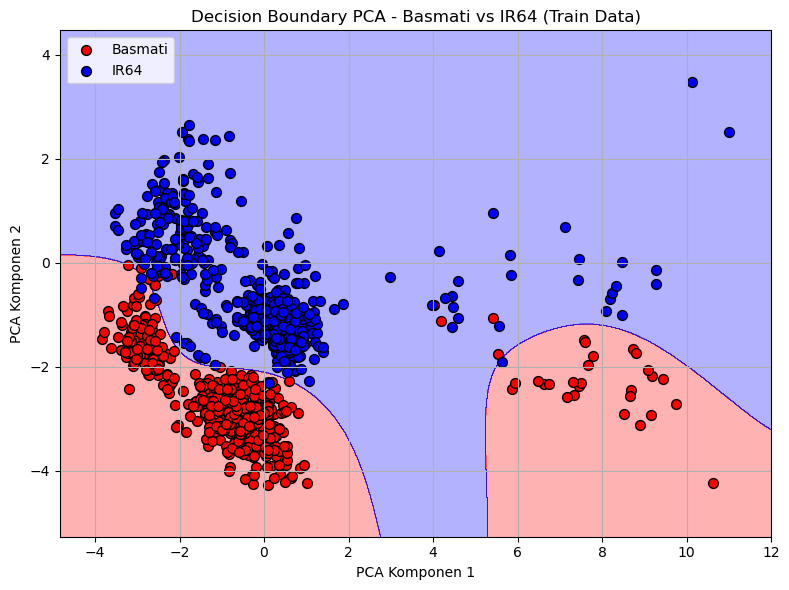

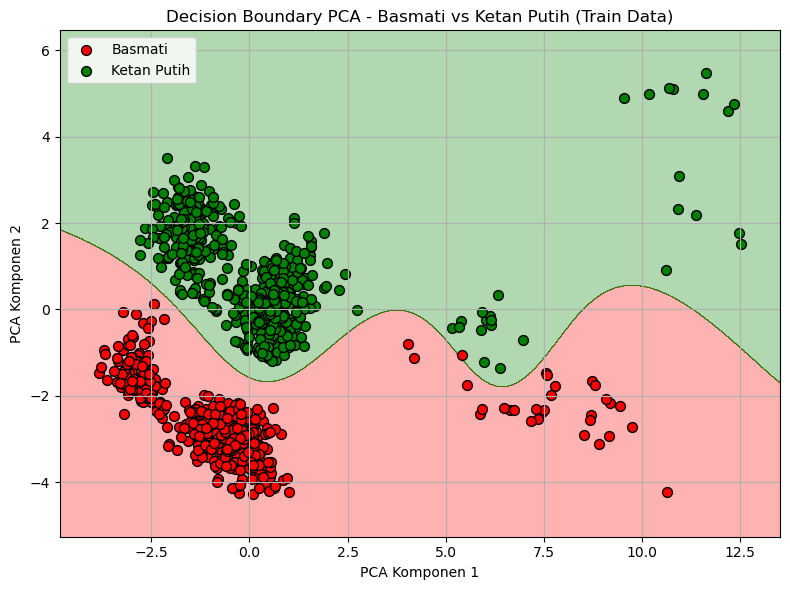

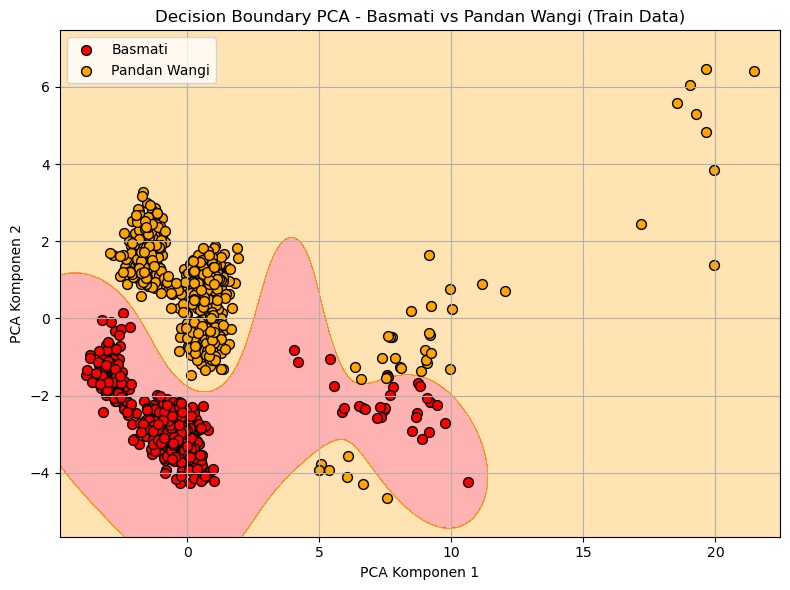

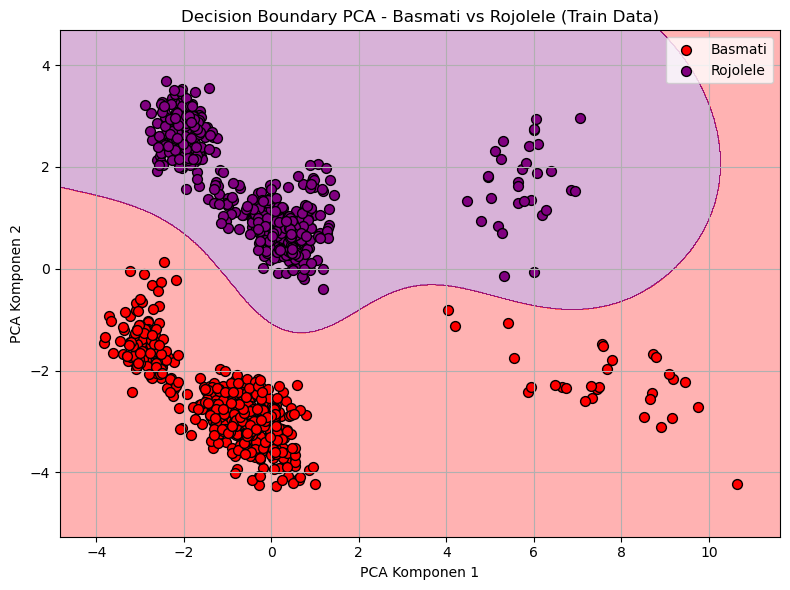

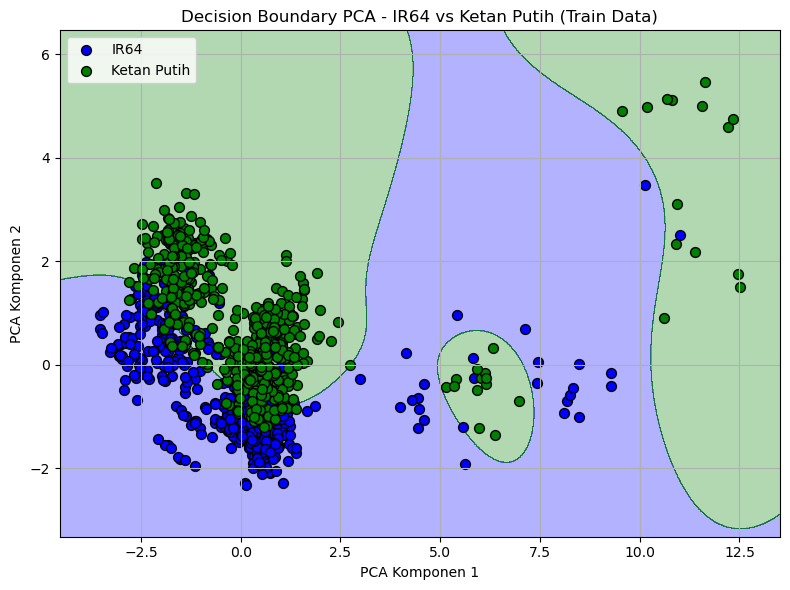

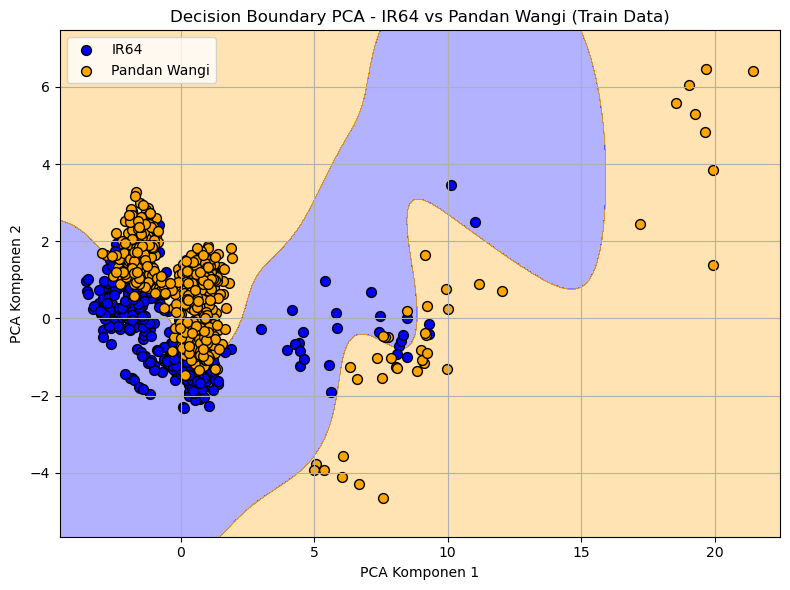

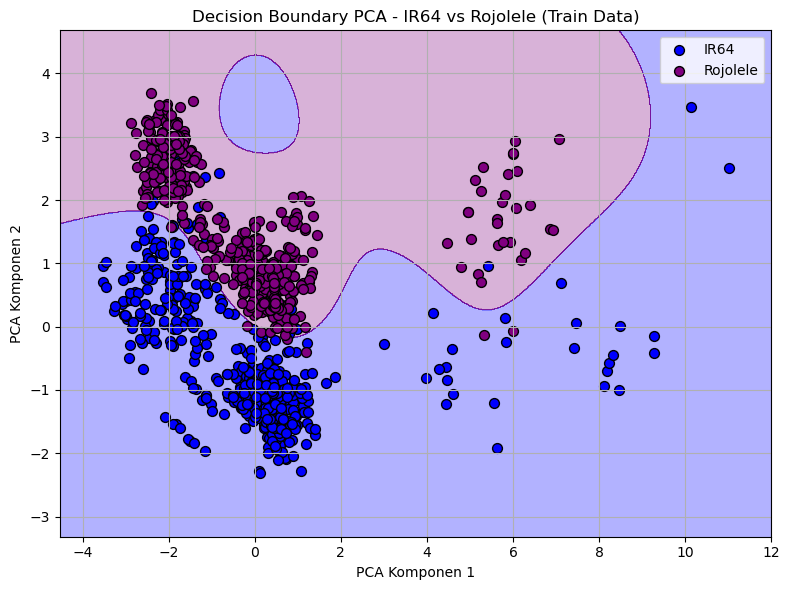

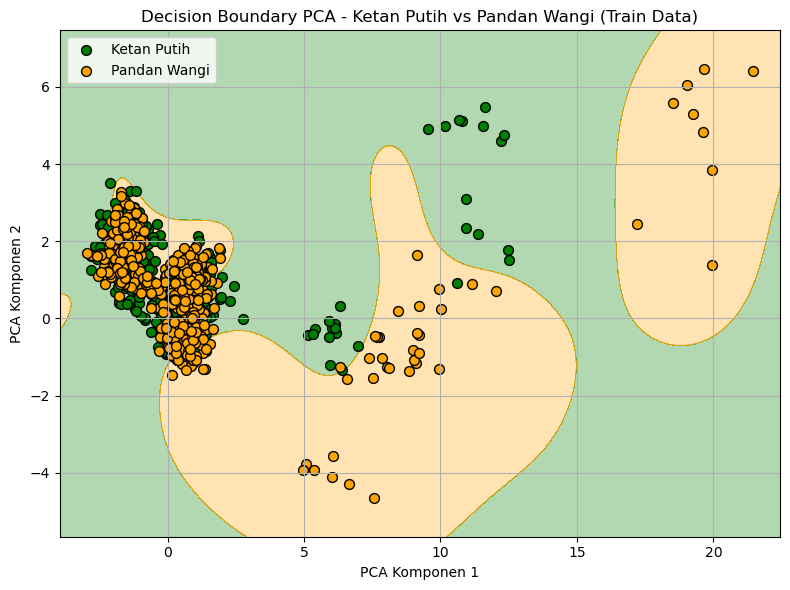

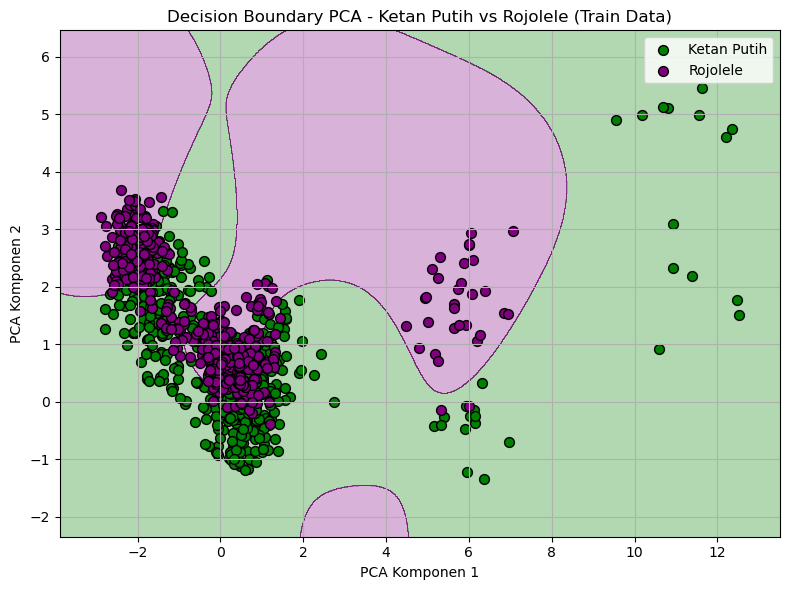

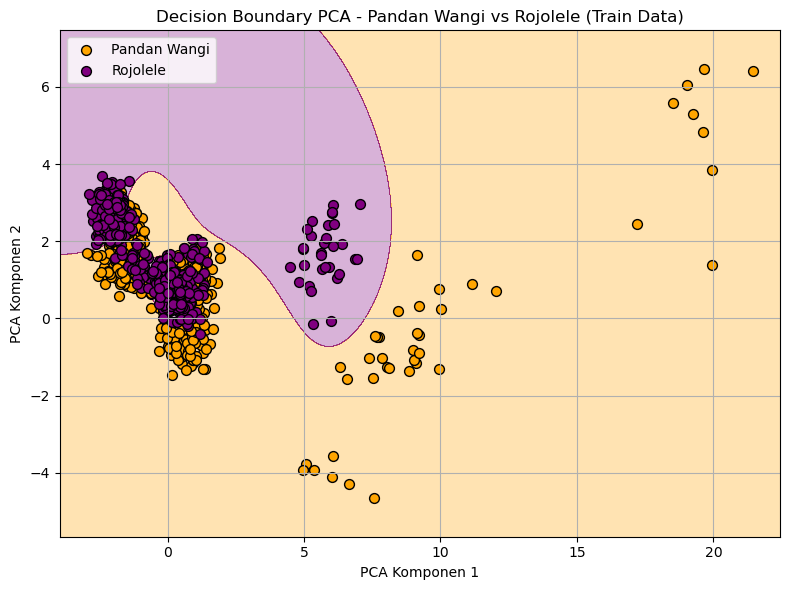

In [119]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from itertools import combinations

# Warna per kelas
label_color_map = {
    "Basmati": "red",
    "IR64": "blue",
    "Ketan Putih": "green",
    "Pandan Wangi": "orange",
    "Rojolele": "purple"
}

# PCA pada data training
pca_train = PCA(n_components=2)
X_train_pca = pca_train.fit_transform(X_train_scaled)

# Kombinasi pasangan kelas
class_pairs = list(combinations(label_color_map.keys(), 2))

for class_a, class_b in class_pairs:
    # Filter data untuk dua kelas saja
    mask = (y_train == class_a) | (y_train == class_b)
    X_pair = X_train_pca[mask]
    y_pair = y_train[mask]

    # Encode label menjadi 0 dan 1
    le = LabelEncoder()
    y_pair_enc = le.fit_transform(y_pair)

    # Latih ulang SVM untuk 2 kelas dengan parameter terbaik dari best_model
    svm = SVC(kernel='rbf', C=best_model.C, gamma=best_model.gamma)
    svm.fit(X_pair, y_pair_enc)

    # Buat meshgrid untuk boundary
    x_min, x_max = X_pair[:, 0].min() - 1, X_pair[:, 0].max() + 1
    y_min, y_max = X_pair[:, 1].min() - 1, X_pair[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Colormap untuk dua kelas
    cmap_pair = ListedColormap([label_color_map[class_a], label_color_map[class_b]])

    # Plot decision boundary
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_pair)

    # Plot titik data
    for class_name in [class_a, class_b]:
        idx = (y_pair == class_name)
        plt.scatter(X_pair[idx, 0], X_pair[idx, 1],
                    color=label_color_map[class_name],
                    label=class_name,
                    edgecolor='k', s=50)

    plt.title(f"Decision Boundary PCA - {class_a} vs {class_b} (Train Data)")
    plt.xlabel("PCA Komponen 1")
    plt.ylabel("PCA Komponen 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


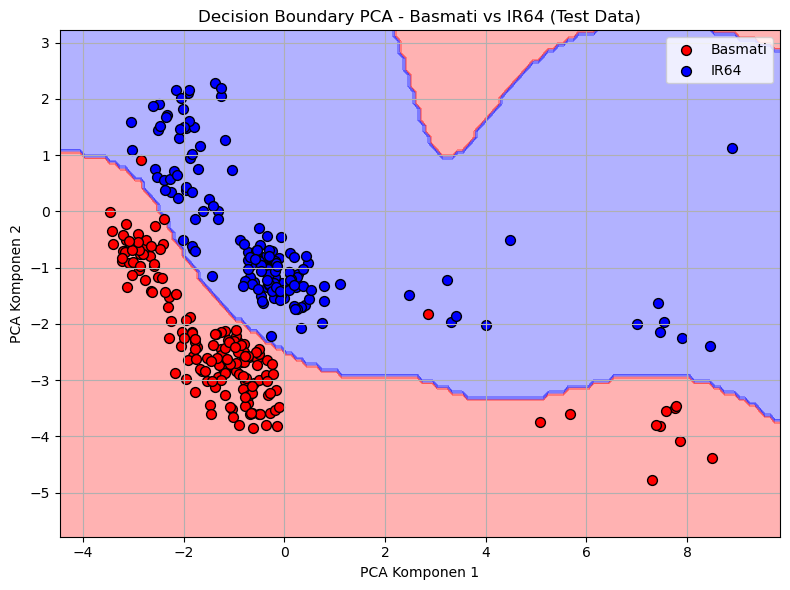

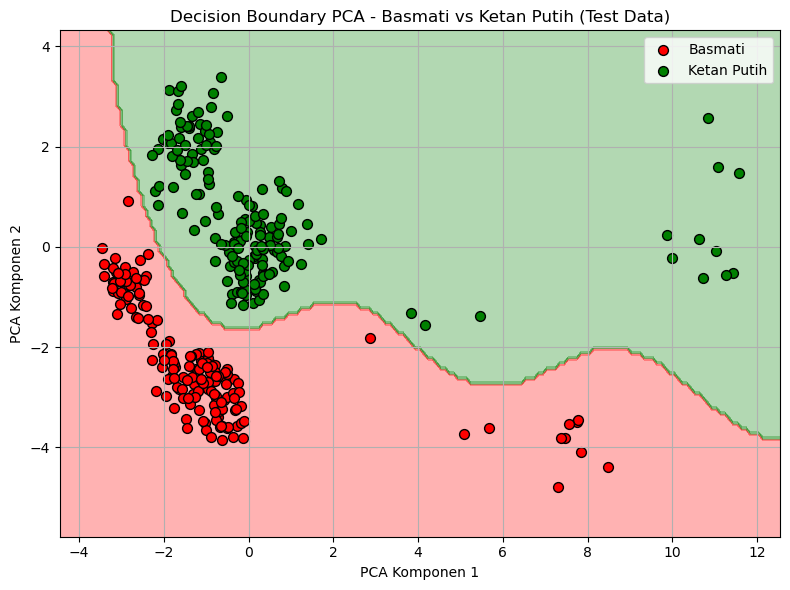

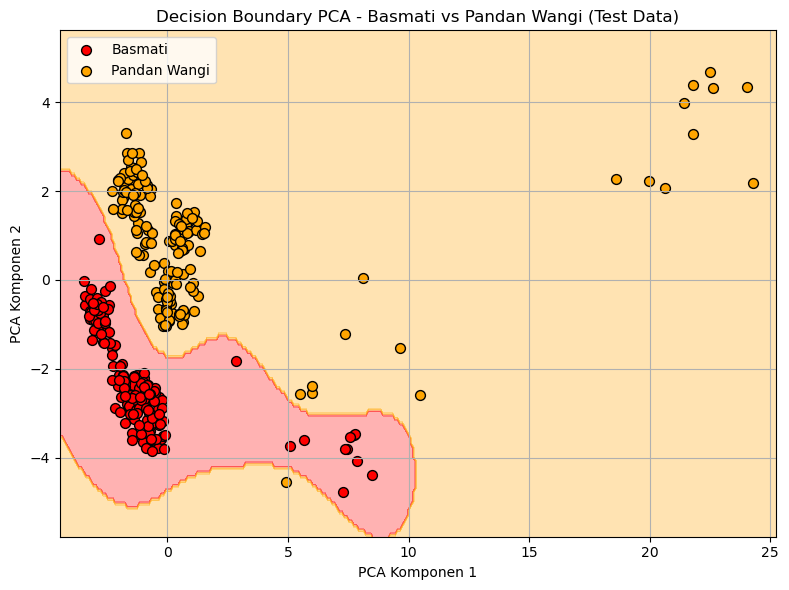

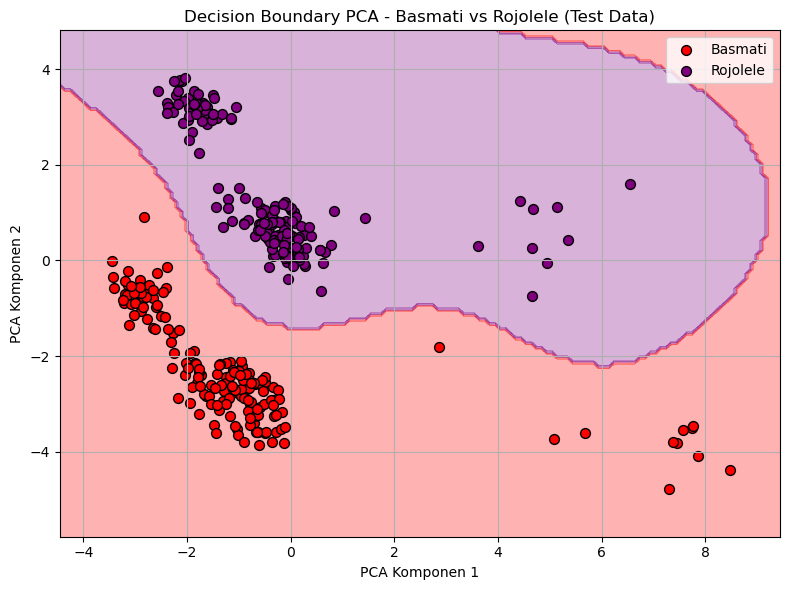

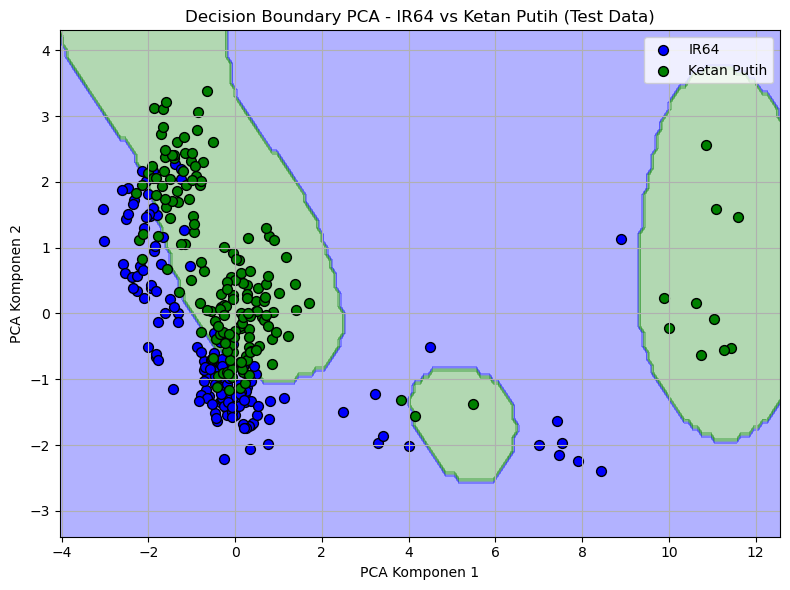

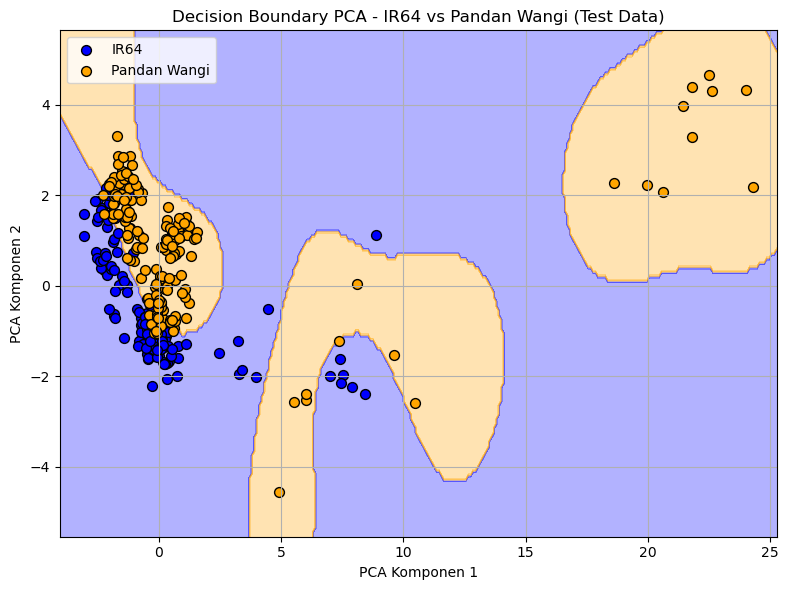

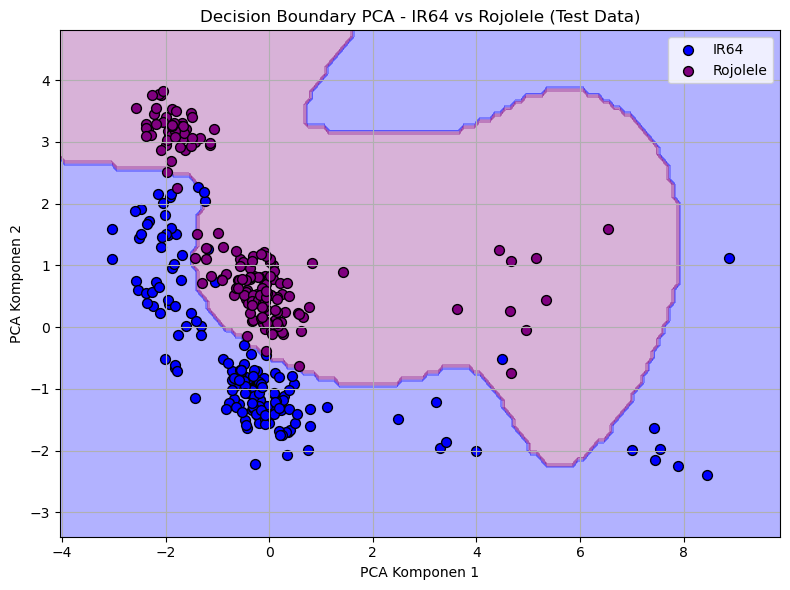

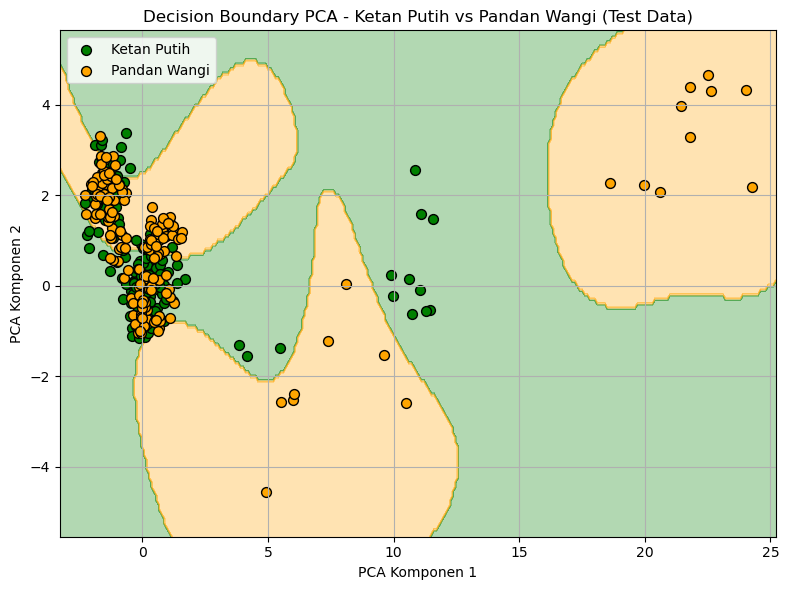

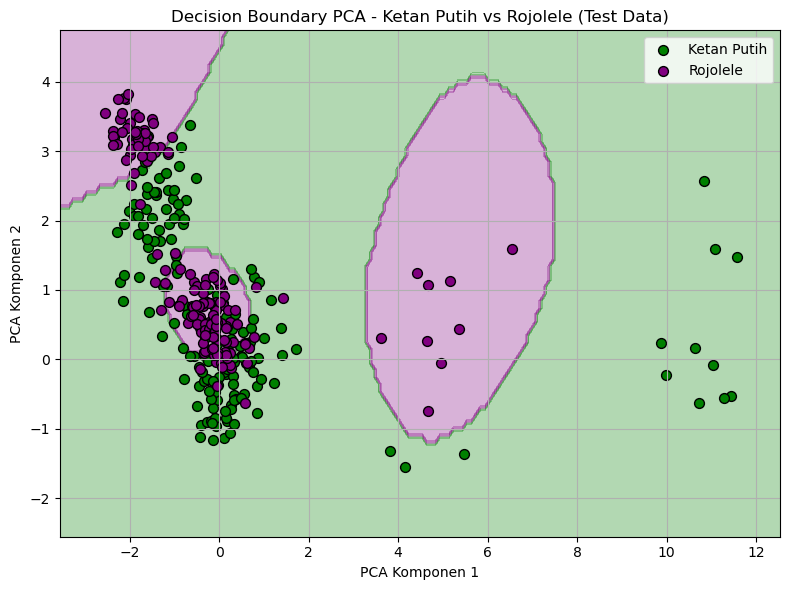

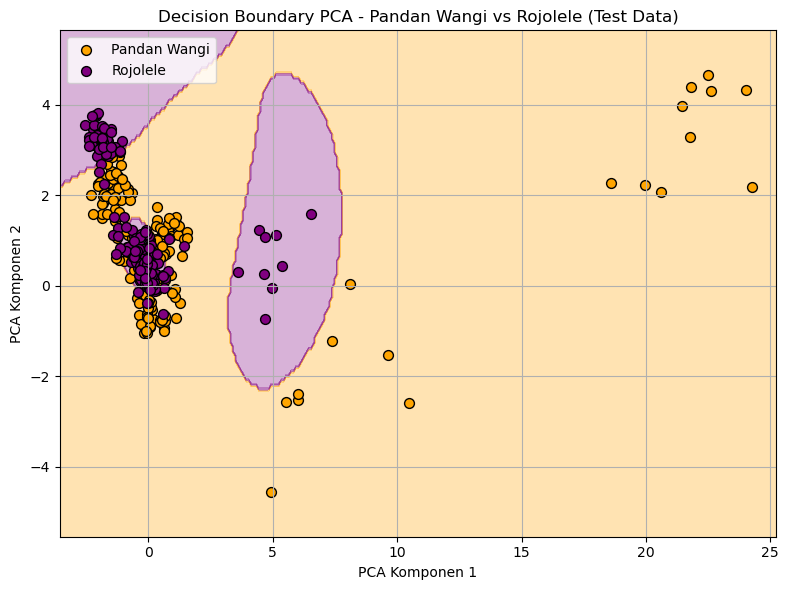

In [120]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from itertools import combinations

# Warna per kelas
label_color_map = {
    "Basmati": "red",
    "IR64": "blue",
    "Ketan Putih": "green",
    "Pandan Wangi": "orange",
    "Rojolele": "purple"
}

# PCA pada data uji
pca_test = PCA(n_components=2)
X_test_pca = pca_test.fit_transform(X_test_scaled)

# Kombinasi pasangan kelas
class_pairs = list(combinations(label_color_map.keys(), 2))

for class_a, class_b in class_pairs:
    # Filter data dua kelas
    mask = (y_test == class_a) | (y_test == class_b)
    X_pair = X_test_pca[mask]
    y_pair = y_test[mask]

    # Encode label menjadi 0 dan 1
    le = LabelEncoder()
    y_pair_enc = le.fit_transform(y_pair)

    # Latih SVM menggunakan parameter terbaik dari hasil GridSearch
    svm = SVC(kernel='rbf', C=best_model.C, gamma=best_model.gamma)
    svm.fit(X_pair, y_pair_enc)

    # Buat meshgrid
    x_min, x_max = X_pair[:, 0].min() - 1, X_pair[:, 0].max() + 1
    y_min, y_max = X_pair[:, 1].min() - 1, X_pair[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Colormap untuk dua kelas
    cmap_pair = ListedColormap([label_color_map[class_a], label_color_map[class_b]])

    # Plot boundary dan titik data
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_pair)

    for class_name in [class_a, class_b]:
        idx = (y_pair == class_name)
        plt.scatter(X_pair[idx, 0], X_pair[idx, 1],
                    color=label_color_map[class_name],
                    label=class_name,
                    edgecolor='k', s=50)

    plt.title(f"Decision Boundary PCA - {class_a} vs {class_b} (Test Data)")
    plt.xlabel("PCA Komponen 1")
    plt.ylabel("PCA Komponen 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


#### Dalam Grid

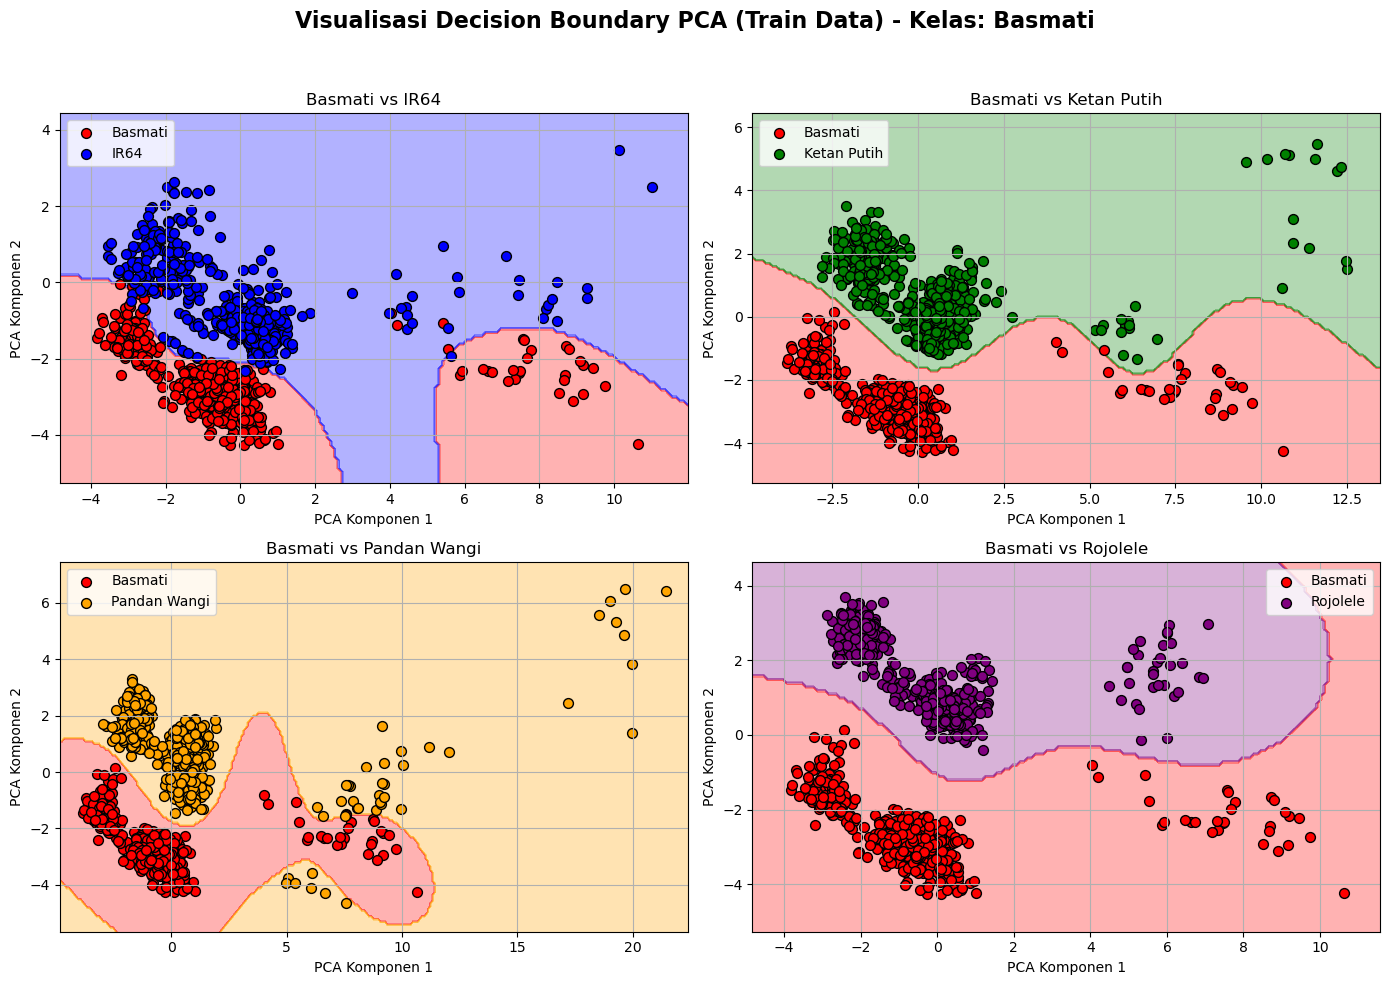

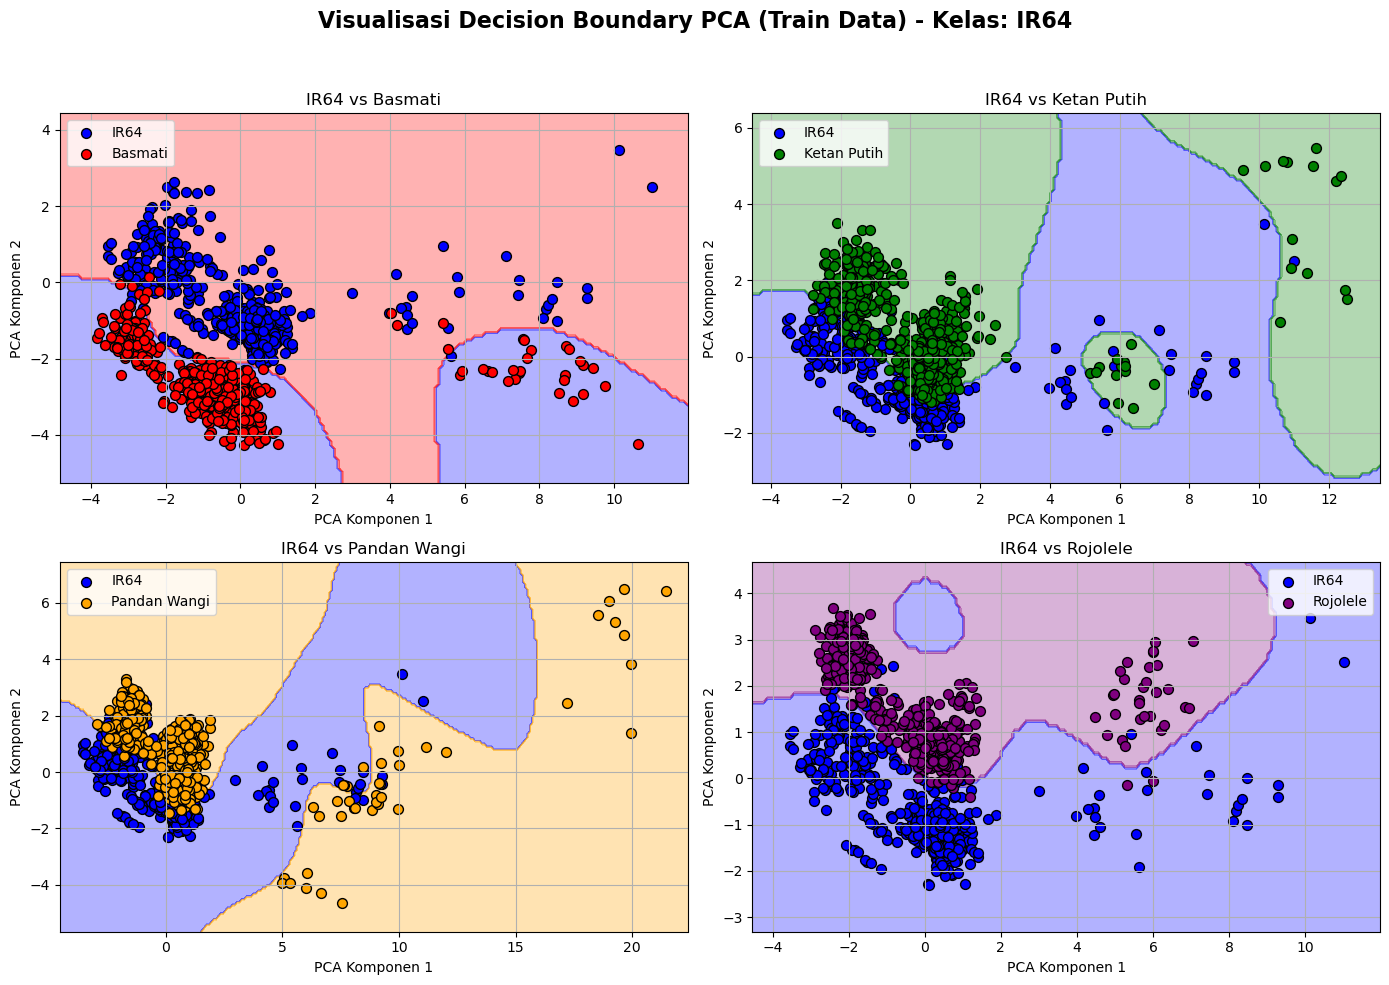

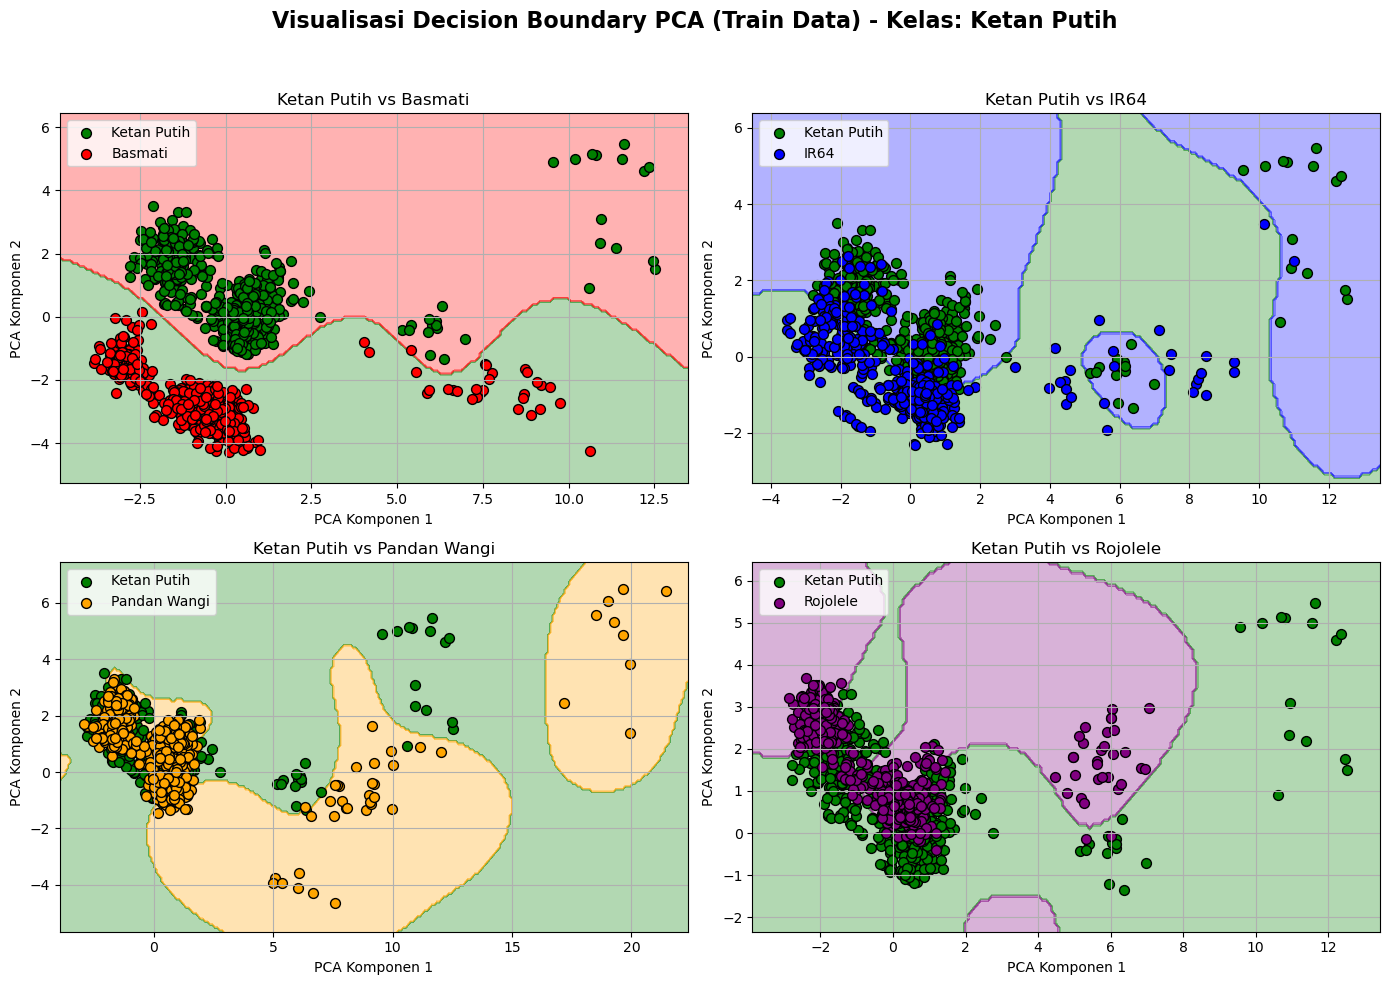

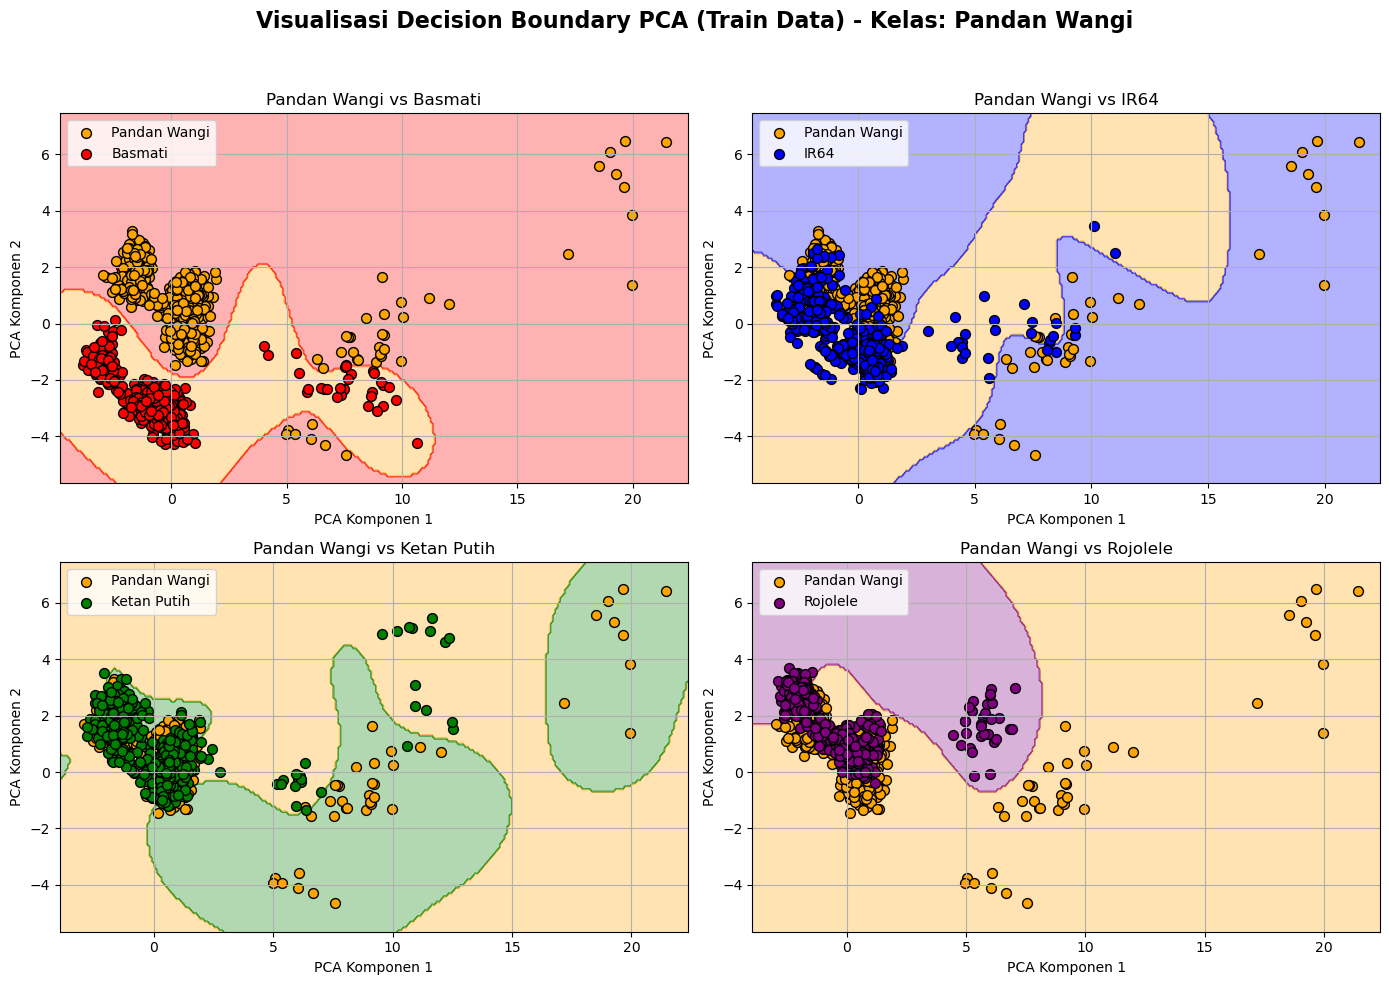

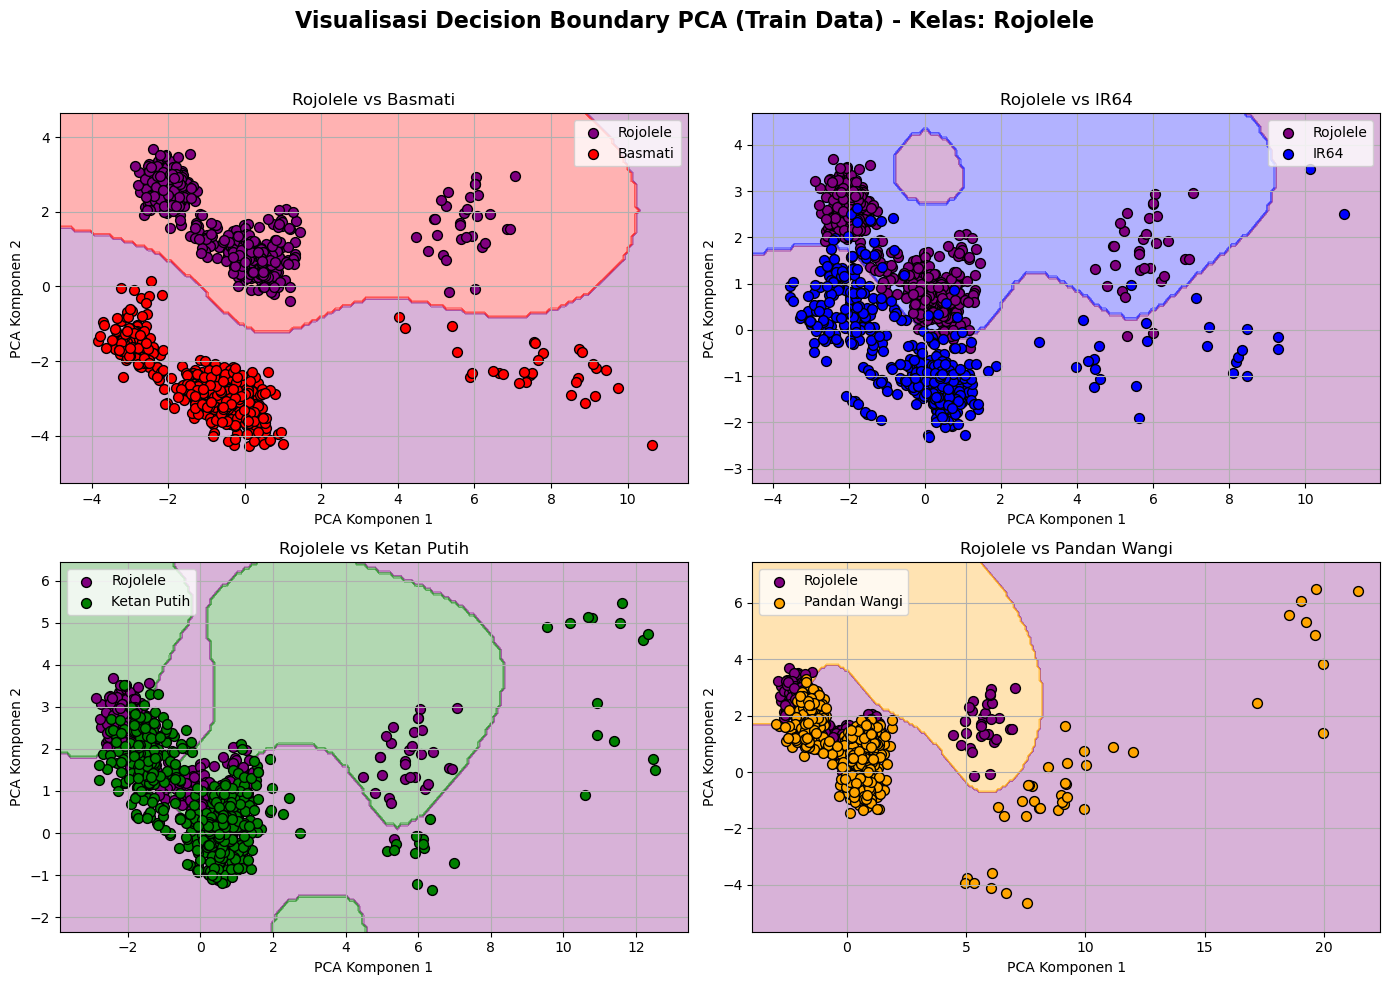

In [121]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np

# === Konfigurasi warna tetap untuk setiap kelas ===
label_color_map = {
    "Basmati": "red",
    "IR64": "blue",
    "Ketan Putih": "green",
    "Pandan Wangi": "orange",
    "Rojolele": "purple"
}
label_list = list(label_color_map.keys())

# === PCA untuk data training
pca_train = PCA(n_components=2)
X_train_pca = pca_train.fit_transform(X_train_scaled)

# === Loop per kelas utama (melawan 4 lainnya)
for main_class in label_list:
    other_classes = [cls for cls in label_list if cls != main_class]

    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"Visualisasi Decision Boundary PCA (Train Data) - Kelas: {main_class}", fontsize=16, fontweight='bold')

    for i, other_class in enumerate(other_classes):
        row, col = divmod(i, 2)
        ax = axs[row][col]

        # Filter dua kelas
        mask = (y_train == main_class) | (y_train == other_class)
        X_pair = X_train_pca[mask]
        y_pair = y_train[mask]

        # Encode label
        le = LabelEncoder()
        y_pair_enc = le.fit_transform(y_pair)

        # Gunakan parameter hasil tuning terbaik
        svm = SVC(kernel='rbf', C=best_model.C, gamma=best_model.gamma)
        svm.fit(X_pair, y_pair_enc)

        # Meshgrid
        x_min, x_max = X_pair[:, 0].min() - 1, X_pair[:, 0].max() + 1
        y_min, y_max = X_pair[:, 1].min() - 1, X_pair[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                             np.arange(y_min, y_max, 0.1))
        Z = svm.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

        # Colormap
        cmap_pair = ListedColormap([label_color_map[main_class], label_color_map[other_class]])

        # Plot boundary
        ax.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_pair)

        # Plot titik
        for label in [main_class, other_class]:
            idx = (y_pair == label)
            ax.scatter(X_pair[idx, 0], X_pair[idx, 1],
                       color=label_color_map[label],
                       label=label,
                       edgecolor='k',
                       s=50)

        ax.set_title(f"{main_class} vs {other_class}")
        ax.set_xlabel("PCA Komponen 1")
        ax.set_ylabel("PCA Komponen 2")
        ax.grid(True)
        ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


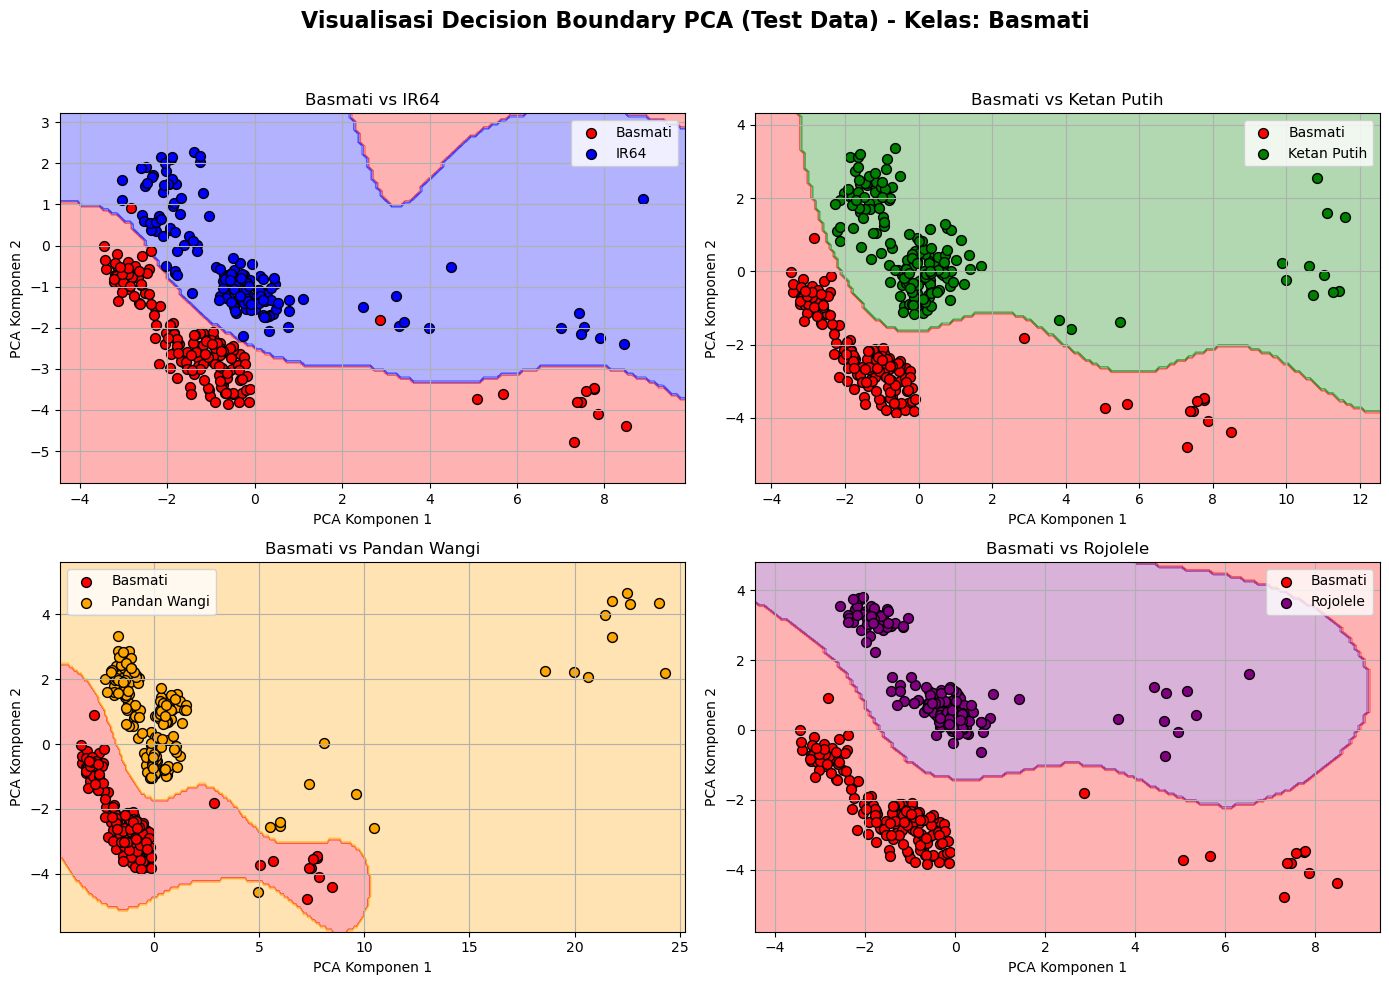

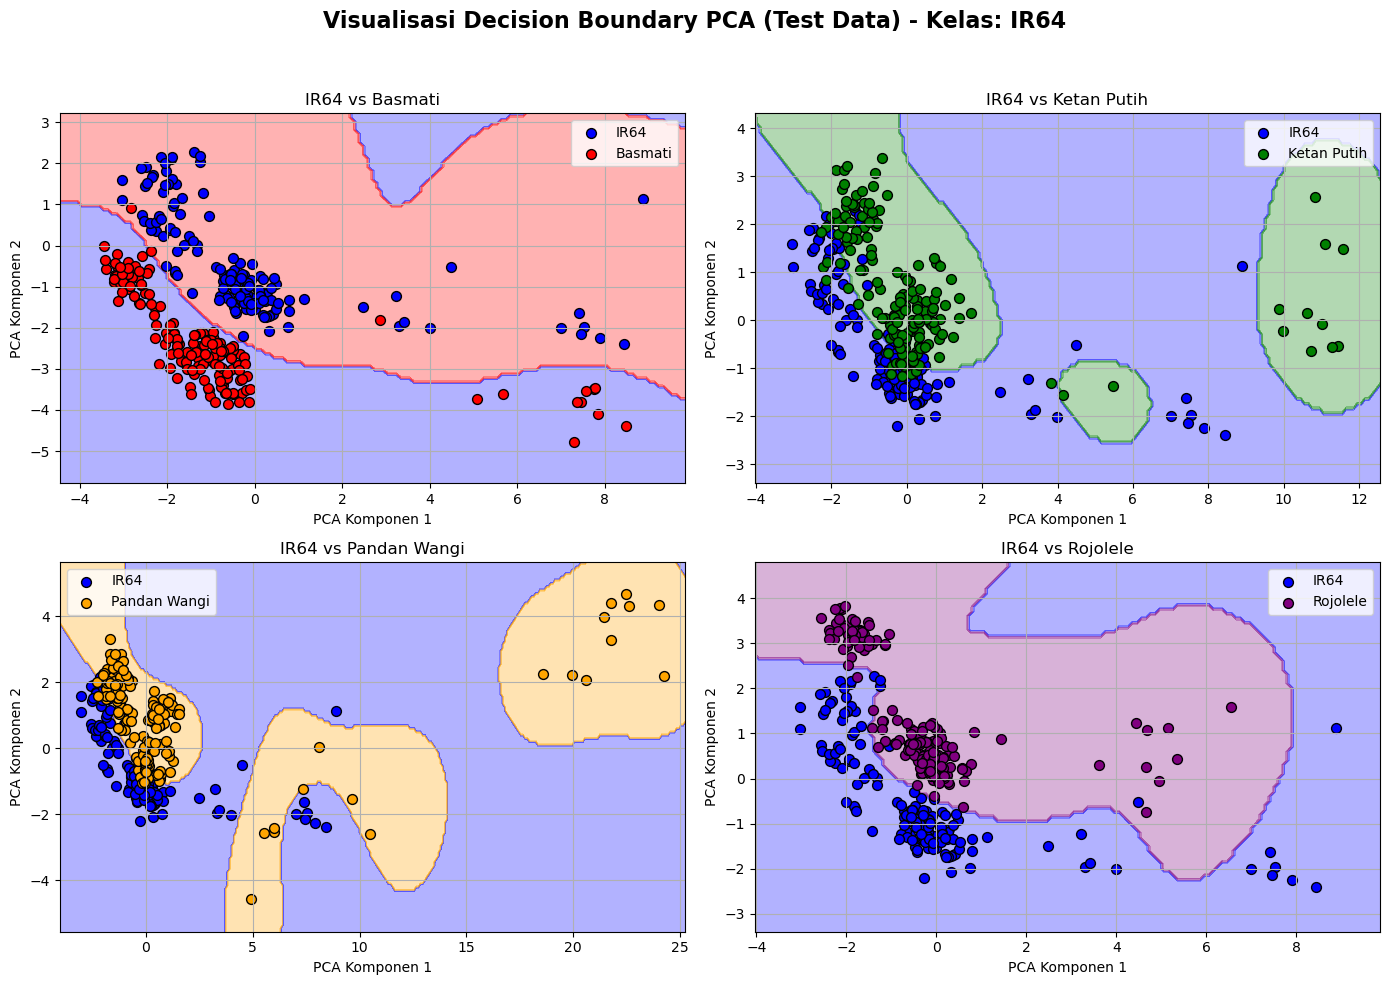

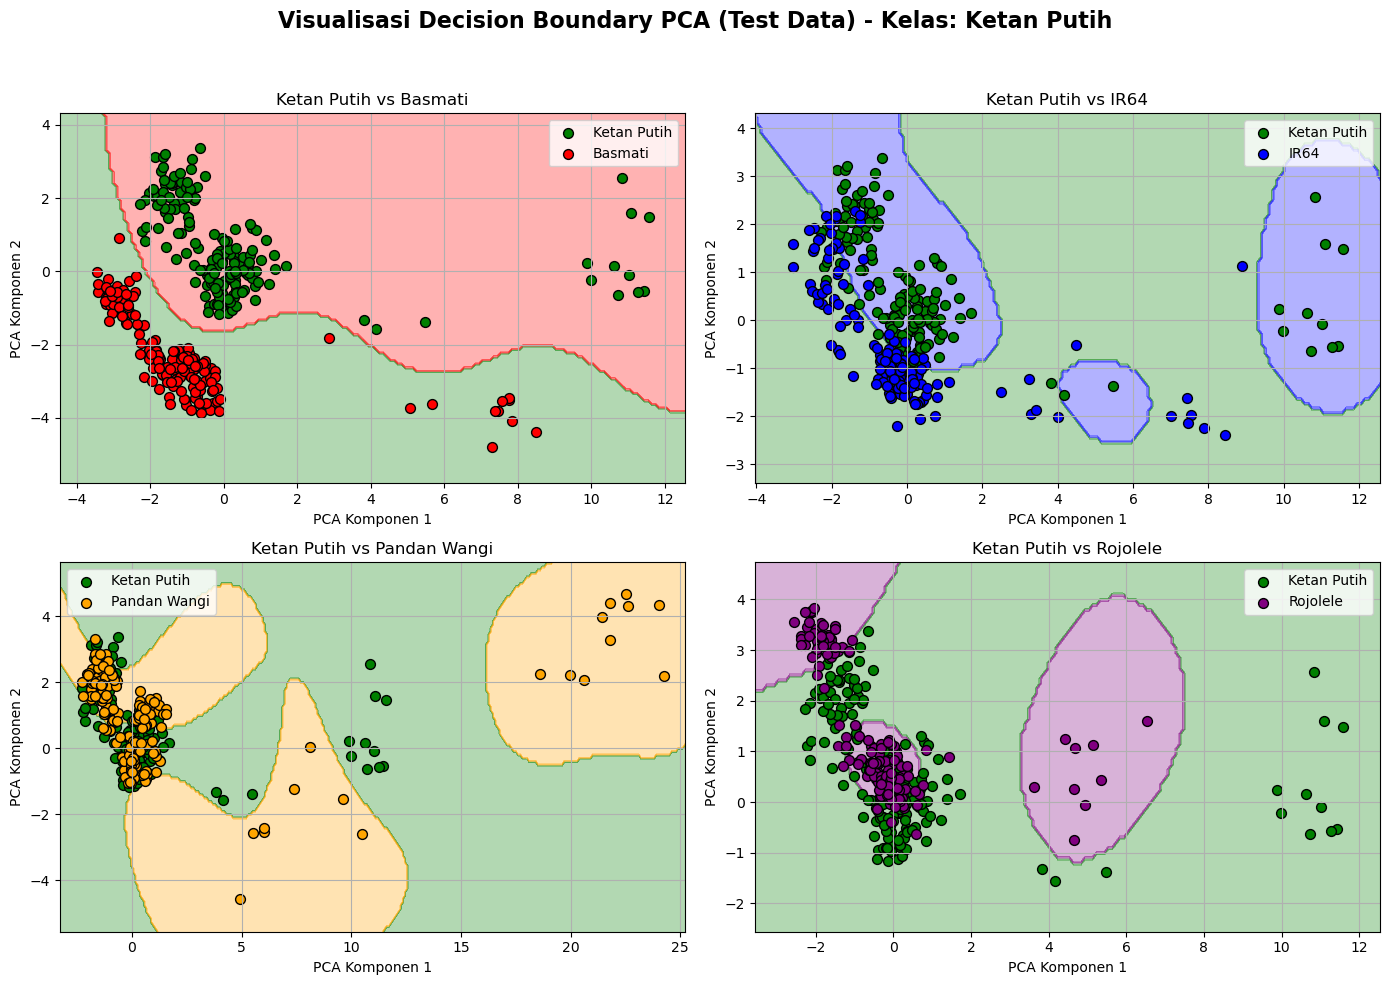

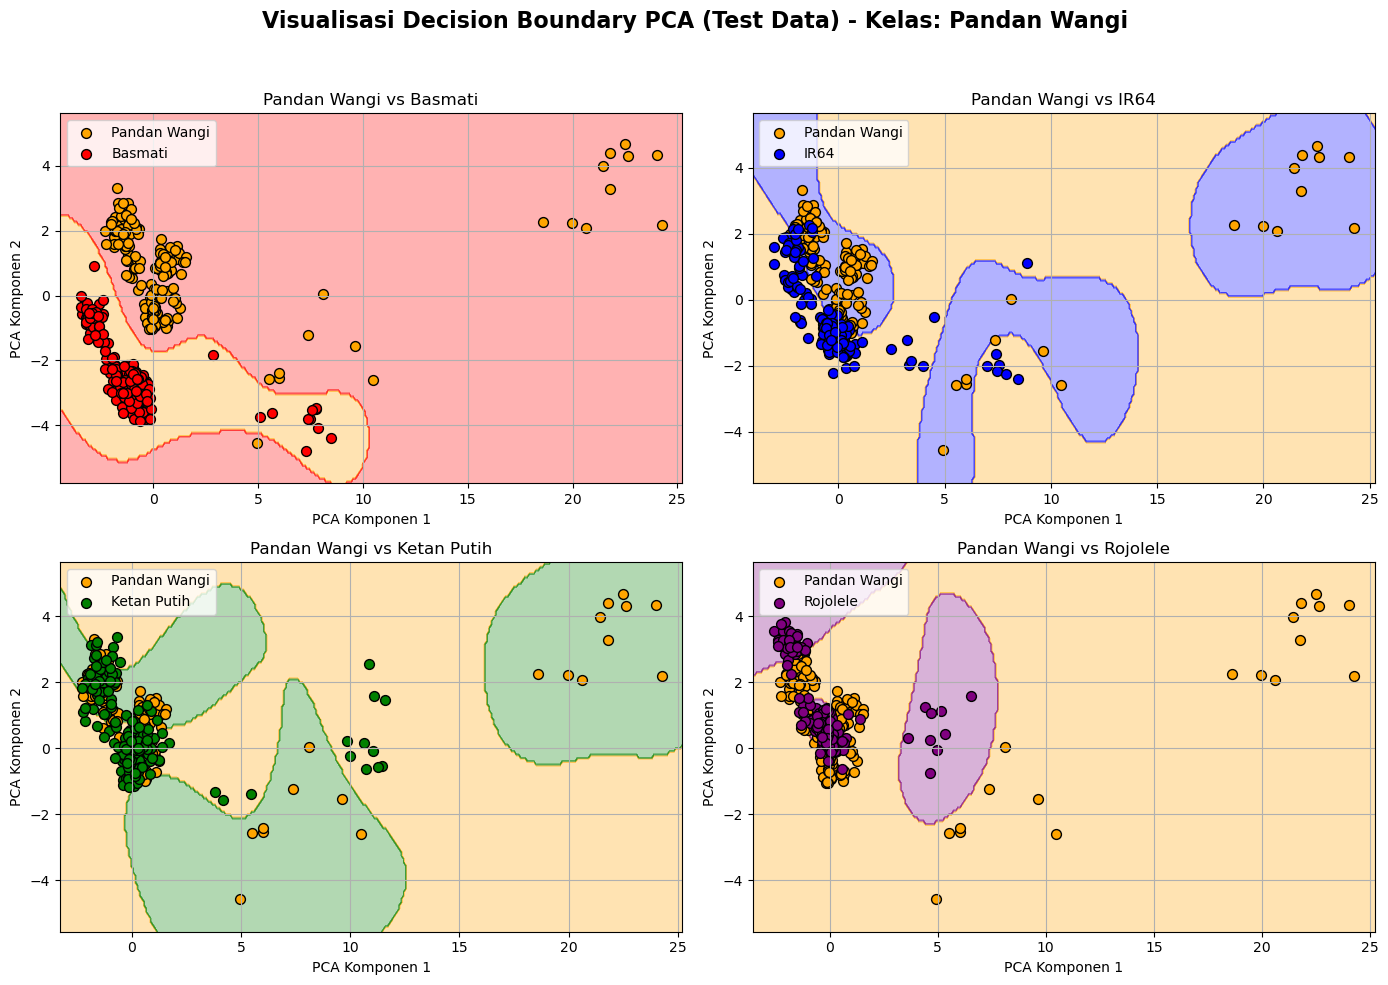

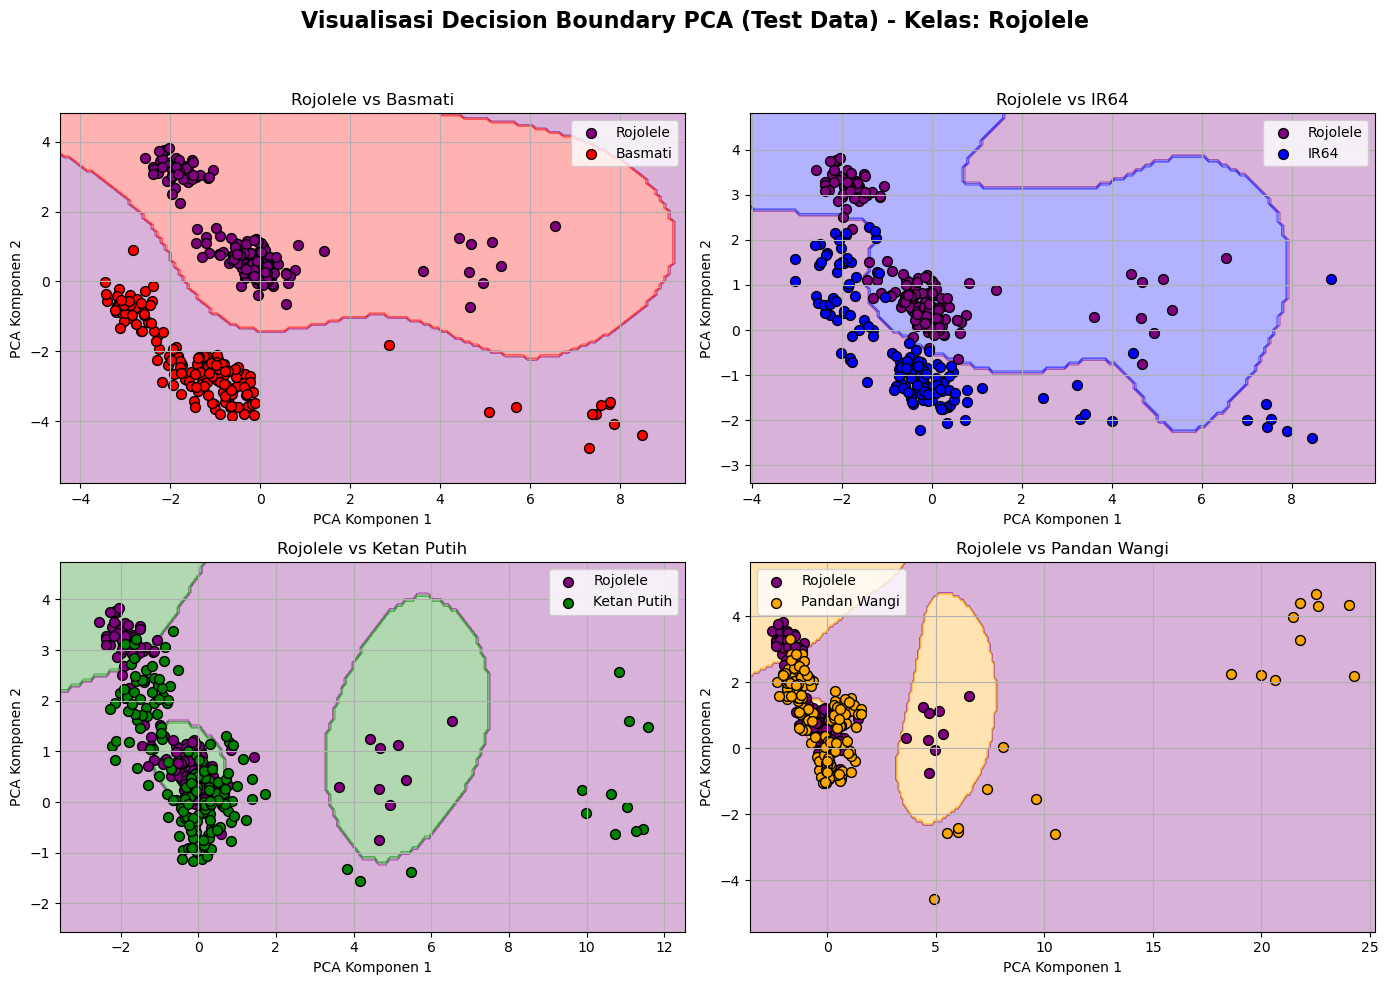

In [122]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations

# === Konfigurasi warna label ===
label_color_map = {
    "Basmati": "red",
    "IR64": "blue",
    "Ketan Putih": "green",
    "Pandan Wangi": "orange",
    "Rojolele": "purple"
}
label_list = list(label_color_map.keys())

# === PCA pada data uji
pca_test = PCA(n_components=2)
X_test_pca = pca_test.fit_transform(X_test_scaled)

# === Encode label global
le_all = LabelEncoder()
le_all.fit(label_list)

# === Visualisasi tiap kelas utama melawan 4 lainnya
for main_class in label_list:
    other_classes = [cls for cls in label_list if cls != main_class]

    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"Visualisasi Decision Boundary PCA (Test Data) - Kelas: {main_class}", fontsize=16, fontweight='bold')

    for i, other_class in enumerate(other_classes):
        row, col = divmod(i, 2)
        ax = axs[row][col]

        # Filter dua kelas saja
        mask = (y_test == main_class) | (y_test == other_class)
        X_pair = X_test_pca[mask]
        y_pair = y_test[mask]

        # Encode lokal label
        le = LabelEncoder()
        y_pair_enc = le.fit_transform(y_pair)

        # Gunakan parameter hasil tuning terbaik
        svm = SVC(kernel='rbf', C=best_model.C, gamma=best_model.gamma)
        svm.fit(X_pair, y_pair_enc)

        # Meshgrid
        x_min, x_max = X_pair[:, 0].min() - 1, X_pair[:, 0].max() + 1
        y_min, y_max = X_pair[:, 1].min() - 1, X_pair[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                             np.arange(y_min, y_max, 0.1))
        Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        cmap_pair = ListedColormap([label_color_map[main_class], label_color_map[other_class]])

        # Plot boundary
        ax.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_pair)

        # Plot titik data
        for label in [main_class, other_class]:
            idx = (y_pair == label)
            ax.scatter(X_pair[idx, 0], X_pair[idx, 1],
                       color=label_color_map[label],
                       label=label,
                       edgecolor='k',
                       s=50)

        ax.set_title(f"{main_class} vs {other_class}")
        ax.set_xlabel("PCA Komponen 1")
        ax.set_ylabel("PCA Komponen 2")
        ax.grid(True)
        ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


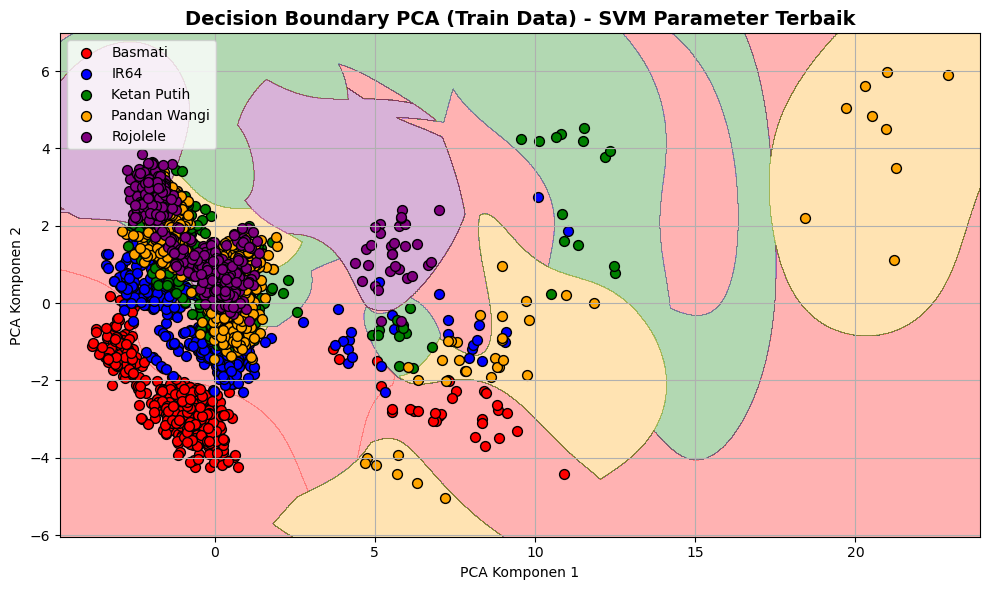

In [123]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.svm import SVC

# === Warna untuk setiap kelas ===
label_color_map = {
    "Basmati": "red",
    "IR64": "blue",
    "Ketan Putih": "green",
    "Pandan Wangi": "orange",
    "Rojolele": "purple"
}
label_order = list(label_color_map.keys())
cmap_boundary = ListedColormap([label_color_map[label] for label in label_order])

# === Gabungkan data latih & uji untuk PCA
X_vis = np.vstack([X_train_scaled, X_test_scaled])
y_vis = np.hstack([y_train, y_test])

# === Encoding label
le = LabelEncoder()
le.fit(label_order)
y_encoded = le.transform(y_vis)
y_train_enc = y_encoded[:len(X_train_scaled)]

# === PCA reduksi ke 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_vis)
X_train_pca = X_pca[:len(X_train_scaled)]

# === Latih ulang SVM pada data PCA menggunakan parameter terbaik
svm_pca = SVC(kernel='rbf', C=best_model.C, gamma=best_model.gamma)
svm_pca.fit(X_train_pca, y_train_enc)

# === Buat meshgrid untuk prediksi boundary
X1, X2 = np.meshgrid(
    np.arange(X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1, 0.01),
    np.arange(X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1, 0.01)
)
Z = svm_pca.predict(np.c_[X1.ravel(), X2.ravel()]).reshape(X1.shape)

# === Plot visualisasi
plt.figure(figsize=(10, 6))
plt.contourf(X1, X2, Z, alpha=0.3, cmap=cmap_boundary)

for label in label_order:
    idx = le.transform([label])[0]
    plt.scatter(X_train_pca[y_train_enc == idx, 0],
                X_train_pca[y_train_enc == idx, 1],
                label=label,
                color=label_color_map[label],
                edgecolors='k',
                s=50)

plt.title("Decision Boundary PCA (Train Data) - SVM Parameter Terbaik", fontsize=14, fontweight='bold')
plt.xlabel("PCA Komponen 1")
plt.ylabel("PCA Komponen 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


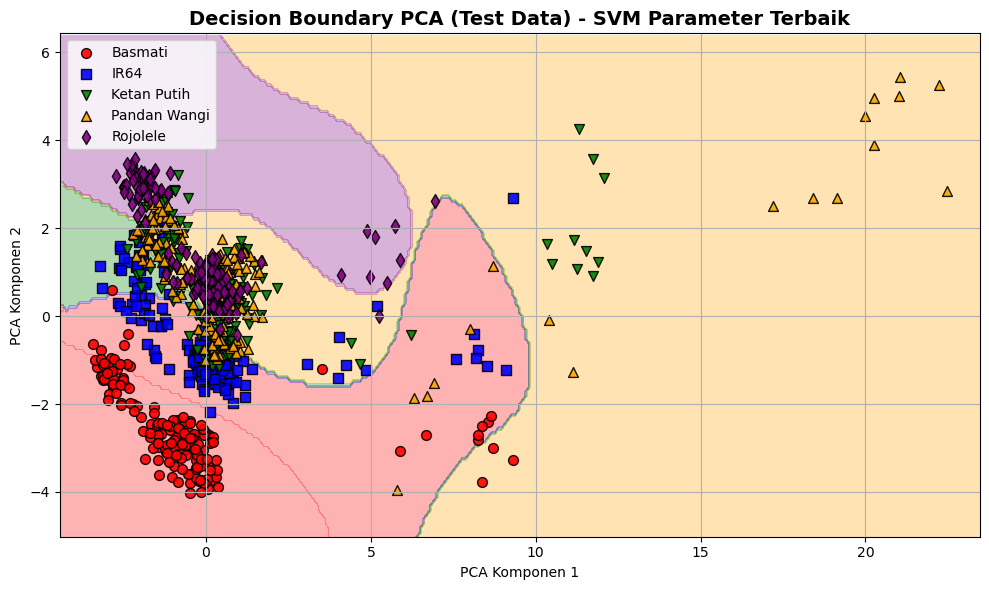

: 

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np

# === Warna dan marker tetap untuk visualisasi kelas ===
label_color_map = {
    "Basmati": "red",
    "IR64": "blue",
    "Ketan Putih": "green",
    "Pandan Wangi": "orange",
    "Rojolele": "purple"
}
label_marker_map = {
    "Basmati": "o",
    "IR64": "s",
    "Ketan Putih": "v",
    "Pandan Wangi": "^",
    "Rojolele": "d"
}
label_order = list(label_color_map.keys())
cmap_background = ListedColormap([label_color_map[label] for label in label_order])

# === PCA pada data test (gunakan objek pca hasil training sebelumnya) ===
X_test_pca = pca.transform(X_test_scaled)

# === Encode label test
le = LabelEncoder()
le.fit(label_order)
y_test_encoded = le.transform(y_test)

# === Meshgrid untuk boundary
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Proyeksikan kembali ke fitur asli sebelum prediksi
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_original = pca.inverse_transform(grid_points)
Z_labels = best_model.predict(grid_original)
Z_encoded = le.transform(Z_labels)
Z = Z_encoded.reshape(xx.shape)

# === Plot Decision Boundary dan Titik Data Uji
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_background)

# Plot titik-titik data uji
for label in le.classes_:
    idx = y_test == label
    plt.scatter(X_test_pca[idx, 0],
                X_test_pca[idx, 1],
                label=label,
                color=label_color_map[label],
                marker=label_marker_map[label],
                edgecolor='k',
                s=50,
                alpha=0.9)

plt.title("Decision Boundary PCA (Test Data) - SVM Parameter Terbaik", fontsize=14, fontweight='bold')
plt.xlabel("PCA Komponen 1")
plt.ylabel("PCA Komponen 2")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [1]:
# Membuat requirements.txt hanya dari module yang terimport dalam script
import pkgutil
import sys
import pkg_resources

# Daftar library yang kamu gunakan di siberas.py
used_modules = [
    "streamlit", "cv2", "numpy", "pandas", "joblib",
    "PIL", "pathlib", "base64", "sklearn", "matplotlib"
]

# Normalisasi nama modul ke nama pip package
mapping = {
    "cv2": "opencv-python",
    "PIL": "Pillow",
    "sklearn": "scikit-learn"
}

# Mapping & versi
packages = []
for mod in used_modules:
    pkg_name = mapping.get(mod, mod)
    try:
        ver = pkg_resources.get_distribution(pkg_name).version
        packages.append(f"{pkg_name}=={ver}")
    except:
        packages.append(f"# {pkg_name} (not installed)")

# Simpan ke file
with open("requirements.txt", "w") as f:
    f.write("\n".join(packages))

print("✅ File requirements.txt berhasil dibuat.")


✅ File requirements.txt berhasil dibuat.
